<div class="alert alert-block alert-danger">
<h1>Titanic: Machine Learning from Disaster</h1>
</div>

- Goal is to predict which passengers survived the Titanic shipwreck using passenger data (ie name, age, gender, socio-economic class, etc).

<div class="alert alert-block alert-danger">
<h2>Table of Contents</h2>
</div>

[Functions to be used](#1.0)<br>
    <ul>
        <li>Pandas</li>
        <li>Visualizations</li>
        <li>Confusion matrix and metrics</li>
        <li>Encoding</li>
        <li>KBinsDiscretizer</li>
        <li>Scaler (Standard, MinMax)</li>
        <li>Missing value imputation</li>
    </ul>
[Import Libraries](#2.0)<br>
[Load Data](#3.0)<br>
[Exploratory Data Analysis (EDA)](#4.0)<br>
    <ul>
        <li>[Analyze each feature](#4.1)</li>
    </ul>
[Machine Learning Algorithms and Results](#5.0)<br>
    <ul>
        <li>[Feature engineering](#5.1)</li>
        <li>[Correlation of the features](#5.2)</li>
        <li>[Split Dataframe](#5.3)</li>
        <li>[Overcoming Class Imbalance using SMOTE](#5.4)</li>
        <li>[Building ML models](#5.5)</li>
            <ul>
                <li>Logistic Regression</li>
                <li>Random Forest</li>
                <li>Naive Bayes</li>
                <li>Support Vector</li>
                <li>k-Nearest Neighbours</li>
                <li>Stochastic Gradient Descent</li>
                <li>Gradient-Boosted Tree</li>
                <li>XGBClassifier</li>
            </ul>
        <li>[Model selection - final](#5.6)</li>
        <li>[Evaluation of the selected model](#5.7)</li>
            <ul>
                <li>ROC/AUC</li>
                <li>TPR/TNR - Threshold</li>
                <li>Precision(PPV)/NPV - Recall</li>
                <li>Accuracy - Threshold</li>
            </ul>
    </ul>
[Submission](#6.0)<br>
    <ul>
        <li>[Results on the Kaggle website](#6.1)</li>
    </ul>

<a id='1.0'></a>
<div class="alert alert-block alert-danger">
<h2>Functions to be used</h2>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Pandas
    </h4>
</div>

In [1]:
def count_null_columns(df):
    df_null = pd.DataFrame(df.isnull().sum(), columns=['count'])
    df_null = df_null[df_null["count"] != 0]
    if len(df_null.index) > 0:
        return df_null[df_null['count']>0]
    else:
        print("There are no null values in the dataframe.")

In [2]:
def percentCol(df, col):
    df1 = df.groupby(col)[col].count().rename("count").reset_index().sort_values("count", ascending=False)
    df1["percentage (%)"] = 100*df1["count"] / df1["count"].sum()
    df1 = df1.round({"percentage (%)": 1})
#     df1 = df1.fillna('nan')
    df1.set_index(df1.columns[0], inplace=True)
    if len(df1) > 10:
        df1 = df1[:8]
        print("The first 8 items have been plotted.")
    return df1

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

def evaluate_model(model, X_train, y_train, X_test, y_test, params):
    cv = GridSearchCV(estimator=model, cv=10, scoring='accuracy', param_grid=params, 
#                        n_jobs=-1
                     ).fit(X_train, y_train)
    y_pred = cv.predict(X_test)
    y_pred_proba = cv.predict_proba(X_test)
#     print(y_pred)
#     print(cv_pred)
    
    model_cm = confusion_matrix(y_test, y_pred)
    model_cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
    model_cm_metrics = confusion_matrix_func(model_cm, model_cm_norm)
    
    return model_cm_metrics, y_pred_proba

<div class="alert alert-block alert-success">
    <h4>
        Visualizations
    </h4>
</div>

In [4]:
# plot a stacked bar chart to show how a feature is categorized using the another feature
def stacked_bar_chart(df_target, target_col, col, figsize=(8,5)):
    
    df = df_target.groupby([target_col])[col].value_counts(dropna=False).to_frame()\
        .rename(columns={col: 'count'}).reset_index()\
        .pivot(index=target_col, columns=col, values='count').fillna(0)
    
    df["sum_each"] = df.iloc[:,0] + df.iloc[:,1]
    df.sort_values("sum_each", ascending=False, inplace=True)
    df.drop("sum_each", axis=1, inplace=True)

    if len(df) > 10:
        df = df.iloc[:8, :]
        print("The first 8 items have been plotted.")
    
    print(df)
    
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.35
    
    cmap = matplotlib.cm.get_cmap("Set1").colors

    x = [str(i) for i in df.index]
    y = 0
    for i, col_group in enumerate(df.columns):
        try:
            ax.bar(x, df[col_group].values, width, bottom=y, color=cmap[i], label=df.columns[i], 
                   zorder=3)
        except:
            ax.bar(x, df[col_group].values, width, bottom=y, color=cmap(i), label=df.columns[i], 
                   zorder=3)
        y += df[col_group].values
    
    ax.set_xticklabels(x, rotation = 45)
    
    ax.set_xlabel(df.index.name)
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(axis='y', zorder=0, lw=0.2)
        
    plt.show()

In [5]:
def autopct(pct_max, pct, allvals):
    if pct<pct_max:
        return ""
    else:
        absolute = int(round(pct/100.*sum(allvals), 0))
        return "{p:.1f}% \n({val})".format(p=pct, val=absolute)

def pie_chart(df, explode=None, title=None, pct_max=5, legend_pos=(0.8, 0, 0.4, 1), 
              p_theta_max=15, p_theta_min=2):
#     df = df.toPandas().set_index(df.columns[0])
#     df.index.name = None
    items = df.index
    values = df.iloc[:, 0]
    percent = df.iloc[:, 1]
    
    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal"))
    #################################################################
    textprops = dict(horizontalalignment="center", verticalalignment="center", rotation=0, 
                     rotation_mode="anchor", size=12, weight= "bold", color="white")
    wedgeprops=dict(edgecolor="black", linewidth=1)
    labels = [f"{i} ({j} - {k:1.1f}%)" for i,j,k in zip(items, values, percent)]
    #################################################################
    wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: autopct(pct_max, pct, values), 
                                      textprops=textprops, radius=1, startangle=0, counterclock=True, 
                                      pctdistance = 0.6, wedgeprops=wedgeprops, explode=explode)
    #################################################################
    #---------------------------------------------------------------#
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center", ha="center")

    values_2 = [f"{i:1.1f}% ({j})" for i,j in zip(percent, values)]

    for i, p in enumerate(wedges):
        if (p.theta2 - p.theta1 < p_theta_max) & (p.theta2 - p.theta1 > p_theta_min):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            plt.annotate(values_2[i], xy=(x, y), xytext=(1.6*np.sign(x), 1.5*y),
                        horizontalalignment=horizontalalignment, **kw)
    #---------------------------------------------------------------#
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(title, size=16, weight="bold")

    plt.legend(labels=labels, fontsize=12, bbox_to_anchor=legend_pos)
        
    plt.show()

In [6]:
from scipy import stats

def histogram(df, target_col, figsize=(8,5)):
    fig, ax = plt.subplots(figsize=figsize)

#     age_vals = [i[0] for i in df.select(target_col).na.drop().collect()]
    age_vals = [i for i in df[target_col].dropna()]
    
    sigma = df[target_col].dropna().std() # standard deviation of distribution
    mean = df[target_col].dropna().mean() # mean of distribution
    median = np.median(age_vals)
    mode = stats.mode(age_vals)[0][0]   

    x = mean + sigma * np.random.randn(1000)

    # fig, axes = plt.subplots(1, 1, figsize=(16, 6))
    n, bins, patches = ax.hist(age_vals, 20, density=True, color='lightgreen', 
                                           stacked=True, alpha=0.75)

    # add mean, median and mode lines
    ax.axvline(mean, 0, 1, color='red', label='mean: {:.2f}'.format(mean))
    ax.axvline(median, 0, 1, color='blue', label='median: {:.2f}'.format(median))
    ax.axvline(mode, 0, 1, color='green', label='mode: {:.2f}'.format(mode))

    # add a 'best fit' line
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
        np.exp(-0.5 * (1 / sigma * (bins - mean))**2))
    ax.plot(bins, y, '--', color ='black')

    ax.grid(True)
    ax.set_ylabel('Probability')
    ax.set_title(f'{target_col} (sigma={round(sigma, 2)})')
    ax.legend()
    fig.tight_layout()
    fig.show()

<img src="https://miro.medium.com/max/1400/1*2c21SkzJMf3frPXPAR_gZA.png" style="height:250px">

median (Q2/50th Percentile): the middle value of the dataset<br>
first quartile (Q1/25th Percentile): the middle number between the smallest number (not the “minimum”) and the median of the dataset.<br>
third quartile (Q3/75th Percentile): the middle value between the median and the highest value (not the “maximum”) of the dataset.<br>
interquartile range (IQR): 25th to the 75th percentile.<br>
whiskers (shown in blue)<br>
outliers (shown as green circles)<br>
“maximum”: Q3 + 1.5*IQR<br>
“minimum”: Q1 -1.5*IQR<br>

In [7]:
# plot a boxplot to show how the values in the dataset are spread out
def box_plot(df, label):
    fig, ax = plt.subplots(figsize = (10, 1))
    # rectangular box plot
    bplot = ax.boxplot(df,
                           vert=False,  # vertical box alignment
                           notch=True,  # notch shape
                           patch_artist=True,  # fill with color
                           labels=[label]  # will be used to label x-ticks
                          )
    # fill with colors
    colors = ['pink', 'lightblue', 'lightgreen']
    for box in (bplot):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)


    whiskers_1 = bplot['whiskers'][0].get_xdata()[1]
    whiskers_2 = bplot['whiskers'][0].get_xdata()[0]
    median = bplot['medians'][0].get_xdata()[0]
    whiskers_3 = bplot['whiskers'][1].get_xdata()[0]
    whiskers_4 = bplot['whiskers'][1].get_xdata()[1]
    
    ax.text(whiskers_1, 1.15, f"{whiskers_1}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_2, 1.25, f"{whiskers_2}", ha='center', va='center', color='b', size=13)
    ax.text(median, 0.7, f"{median}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_3, 1.25, f"{whiskers_3}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_4, 1.15, f"{whiskers_4}", ha='center', va='center', color='b', size=13)

    ax.xaxis.grid(True)
    plt.show()

    outliers = bplot['fliers'][0].get_xdata()

In [8]:
def balanceOrInbalance(df_label):
    col = df_label.index.name
    uniqs = [str(i) for i in df_label.index]
    vals = [i for i in df_label["count"].values]
    
    fig, ax = plt.subplots(figsize = (12, 2))
    # Horizontal bar chart
    ax.barh(uniqs, vals, align='center', color=['red', 'green'])
    ax.text(vals[0]-vals[0]*0.1, 0, vals[0], ha='center', va='center', color='w', size=20)
    ax.text(vals[1]-vals[1]*0.2, 1, vals[1], ha='center', va='center', color='w', size=20)
    ax.set_ylabel(col)
    ax.set_title('Balance situation in the dependent feature')

    plt.show()

<div class="alert alert-block alert-success">
    <h4>
        Confusion matrix and metrics
    </h4>
</div>

In [9]:
import math

def TP_FP_TN_FN_func(cm, dataframe):
    
    TN, FP, FN, TP = cm.ravel()

    #____________ METRICS ____________#
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round(TP / (TP + FN), 2)
    # Specificity, selectivity or true negative rate (TNR)
    TNR = round(TN / (TN + FP), 2)

    # accuracy (ACC)
    ACC = round((TP + TN) / (TP + TN + FP + FN), 2)
    # balanced accuracy (BA)
    BA = round((TPR + TNR) / 2, 2)

    # Precision or positive predictive value
    PPV = round(TP / (TP + FP), 2)
    # negative predictive value (NPV)
    NPV = round(TN / (TN + FN), 2)
    # false discovery rate (FDR)
    FDR = round(1 - PPV, 2)
    # false omission rate (FOR)
    FOR = round(1 - NPV, 2)

    # prevalence threshold (PT)
    PT = round((math.sqrt(TPR*(1 - TNR)) + TNR - 1)/(TPR + TNR - 1), 2)
    # F1 score
    F1 = round(2*TP / (2*TP + FP + FN), 2)
    # Matthews correlation coefficient (MCC) or phi coefficient
    MCC = round(((TP*TN) - (FP*FN)) / math.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN)), 2)

    # False positive rate or False alarm rate
    FPR = round(FP / (FP + TN), 2)
    # False negative rate or Miss Rate
    FNR = round(FN / (FN + TP), 2)
    

    metrics_cols = ['True Positive Rate', 'True Negative Rate', 'Accuracy', 'Balanced Accuracy', 
                    'Precision', 'Negative Predictive Value', 'False Discovery Rate', 'False Omission Rate', 
                  'Prevalence Threshold', 'F1 Score', 'Matthews Correlation Coefficient', 
                  'False positive rate', 'False Negative Rate']
    df_cm_metrics = pd.DataFrame([[TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, F1, MCC, FPR, FNR]], 
                                 columns=metrics_cols, index=[""])
    
    return df_cm_metrics

def confusion_matrix_func(cm, cm_norm, threshold=0.5):
    cm = cm.astype(int)

    #############################
    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
#     fig, axes = plt.subplots(figsize=(4, 4))

    # Plot the heatmap
    im = axes[0].imshow(cm, interpolation='nearest', cmap='Reds', aspect='auto')
    im_norm = axes[1].imshow(cm_norm, interpolation='nearest', cmap='Reds', aspect='auto')
    
    # show all ticks
    axes[0].set_xticks(np.arange(len(cm.tolist())))
    axes[0].set_yticks(np.arange(len(cm.tolist())))
    axes[1].set_xticks(np.arange(len(cm_norm.tolist())))
    axes[1].set_yticks(np.arange(len(cm_norm.tolist())))

    thresh = cm.max() / 1.5
    # Loop over data dimensions and create text annotations.
    for i in range(len(cm.tolist())):
        for j in range(len(cm.tolist())):
            text = axes[0].text(j, i, cm.tolist()[i][j],
                           ha="center", va="center", size=16,
                           color="white" if cm[i, j] > thresh else "black")
            
    for i in range(len(cm_norm.tolist())):
        for j in range(len(cm_norm.tolist())):
            text = axes[1].text(j, i, f"{round(cm_norm.tolist()[i][j]*100, 1)} %",
                           ha="center", va="center", size=16,
                           color="white" if cm_norm[i, j] > 0.5 else "black")
    # Let the horizontal axes labeling appear on top.
    axes[0].xaxis.set_ticks_position('top')
    axes[0].xaxis.set_label_position('top')
    axes[0].set_xlabel('Predicted value', size=16)
    axes[0].set_ylabel('Actual value', size=16)
    axes[0].set_title("Confusion matrix", fontsize=16, color="blue")

    axes[1].xaxis.set_ticks_position('top')
    axes[1].xaxis.set_label_position('top')
    axes[1].set_xlabel('Predicted value', size=16)
    axes[1].set_ylabel('Actual value', size=16)
    axes[1].set_title("Normalized confusion matrix", fontsize=16, color="blue")
    
    fig.tight_layout()
    fig.show()
    
#     get the metric values as a dataframe
    df_cm_metrics = TP_FP_TN_FN_func(cm, 'Test')
    
    return df_cm_metrics

<div class="alert alert-block alert-success">
    <h4>
        Encoding
    </h4>
</div>

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [10]:
# One Hot Encoding: Encode categorical features as a one-hot numeric array.
# find the unique values per feature and transform the data to a binary one-hot encoding
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def ohe_to_df(df_encoded, ohe_col_name, df_org, ohe_col):
    df_enc = pd.DataFrame(data=df_encoded, columns=ohe_col_name)
    
    # Some rows can be deleted since they are outliers.
    # Therefore, the index numbers are replaced with the existing dataframe
    df_enc.set_index(df_org.index, inplace=True)
    
    # drop the feature to be encoded from the main dataframe and 
    # concatenate the main dataframe with the encoded one
    df_org_dropped = df_org.drop(ohe_col, axis=1)
    df_finished = pd.concat([df_org_dropped, df_enc], axis=1)
    df_finished[ohe_col_name] = df_finished[ohe_col_name].astype(int)
    
    return df_finished
    
# One Hot Encoding the columns.
def one_hot_encoding(train=pd.DataFrame(), test=pd.DataFrame(), ohe_col=None):
    train_for_ohe = train[[ohe_col]]
    
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    # Fit OneHotEncoder to X, then transform X
    ohe.fit(train_for_ohe)
    train_encoded = ohe.transform(train_for_ohe)

    # create feature names for the created binary columns using the feature name to be encoded and uniques
    ohe_col_name = ohe.get_feature_names([ohe_col]).tolist()
    
    df_train_encoded = ohe_to_df(train_encoded, ohe_col_name, train, ohe_col)
    
    if len(test)>0:
        test_for_ohe = test[[ohe_col]]
        test_encoded = ohe.transform(test_for_ohe)
        df_test_encoded = ohe_to_df(test_encoded, ohe_col_name, test, ohe_col)

        return df_train_encoded, df_test_encoded
    return df_train_encoded

In [11]:
# Convert each value in a categorical column to a number from 0 to the number of items-1 by encoding 
def encode_categorical_column(df, col):
    # get unique values
    unique_vals = df[col].value_counts(dropna=True).index.to_list()
    
    if df[col].dtypes == 'object':
        # get a counter in the for loop and replace each unique value with the count to encode 
        for i, j in enumerate(unique_vals):
            df[col].replace(j, i, inplace=True)
    return df

<div class="alert alert-block alert-success">
    <h4>
        KBinsDiscretizer
    </h4>
</div>

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html?highlight=kbinsdiscretizer#sklearn.preprocessing.KBinsDiscretizer

In [12]:
from sklearn.preprocessing import KBinsDiscretizer

def k_bins_discretizer(df, col_kbd, n_bins, strategy):
    kbd = KBinsDiscretizer(n_bins = n_bins, encode = 'ordinal', strategy = strategy)
    df[col_kbd] = kbd.fit_transform(df[col_kbd].values.reshape(-1,1)).astype('int64')

    return df

<div class="alert alert-block alert-success">
    <h4>
        Scaler (Standard, MinMax)
    </h4>
</div>

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def featureScaler(scalerType, train, col=None, test=pd.DataFrame()):
    if scalerType == "standard":
        scaler = StandardScaler()
    elif scalerType == "minMax":
        scaler = MinMaxScaler()
                
    train[col] = scaler.fit_transform(train[[col]])
    if len(test)>0:
        test[col] = scaler.transform(test[[col]])
        return train, test
    return train

<div class="alert alert-block alert-success">
    <h4>
        Missing value imputation
    </h4>
</div>

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html?highlight=iterativeimputer#sklearn.impute.IterativeImputer
- Imputation is the practice of replacing missing values in data with substitute values
- multivariate imputer that estimates each feature from all the others (takes other features into account)
- can be chosen which regression model is used 
- SimpleImputer, (takes only single feature into account)
- IterativeImputer, KNNImputer

Parameters:
- estimator : estimator object, default=BayesianRidge()
- n_nearest_features: Number of other features to use to estimate the missing values of each feature column. 
- initial_strategy: default=’mean’ {“mean”, “median”, “most_frequent”, or “constant”}
- imputation_order: default=’ascending’ {“ascending”, “descending”, “roman”, “arabic”, "random"}
- max_iter default=10: Maximum number of imputation rounds to perform before returning the imputations computed during the final round. 

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

def imputing_missing_values(train, test, col_target, col_drop):
    
    df_corr = pd.DataFrame(abs(train.drop(col_drop, axis=1).corr()[col_target])).sort_values(col_target, 
                                                                                             ascending=False)
    df_corr_list = df_corr[df_corr[col_target] > 0.1].index.tolist()
    
    estimator = RandomForestRegressor(n_jobs=-1)
    imp = IterativeImputer(estimator=estimator, verbose=0, max_iter=10)
    imp.fit(train[df_corr_list])
    df_imp_train = pd.DataFrame(imp.transform(train[df_corr_list]), columns=df_corr_list)
    train[col_target] = df_imp_train[col_target]
    train[col_target] = train[col_target].astype('int64')
    
    df_imp_test = pd.DataFrame(imp.transform(test[df_corr_list]), columns=df_corr_list)
    test[col_target] = df_imp_test[col_target]
    test[col_target] = test[col_target].astype('int64')

    return train, test
# # KNNImputer

# from sklearn.impute import KNNImputer

# knn_imp = KNNImputer(n_neighbors=5)
# knn_imp.fit(train[df_age_corr_list])
# df_age_knnimp = pd.DataFrame(knn_imp.transform(train[df_age_corr_list]))
# df_age_knnimp.head()

<a id='2.0'></a>
<div class="alert alert-block alert-danger">
<h2>Import Libraries</h2>
</div>

In [15]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # ignore information messages

import math
import numpy as np 
import pandas as pd
# display all of the columns
pd.set_option('display.max_columns', None)

import matplotlib     # for cmap color
from matplotlib import pyplot as plt
%matplotlib inline

<a id='3.0'></a>
<div class="alert alert-block alert-danger">
<h2>Load Data</h2>
</div>

In [16]:
train = pd.read_csv("../../all_dfs/titanic/train.csv")
train = train.drop('PassengerId', axis=1)
test = pd.read_csv("../../all_dfs/titanic/test.csv")
test = test.drop('PassengerId', axis=1)
gender_submission = pd.read_csv("../../all_dfs/titanic/gender_submission.csv")

In [17]:
train.tail(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [18]:
test.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [19]:
f"Total transactions: {train.shape[0], test.shape[0]}"

'Total transactions: (891, 418)'

<a id='4.0'></a>
<div class="alert alert-block alert-danger">
<h2>Exploratory Data Analysis (EDA)</h2>
</div>

<a id='4.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Analyze each feature
   </h3>
</div>

<div class="alert alert-block alert-warning">
        Check missing values
</div>

In [20]:
count_null_columns(train)

,count
Age,177
Cabin,687
Embarked,2


In [21]:
count_null_columns(test)

,count
Age,86
Fare,1
Cabin,327


<div class="alert alert-block alert-success">
    <h4>
        Survived
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Distribution of total transactions
</div>

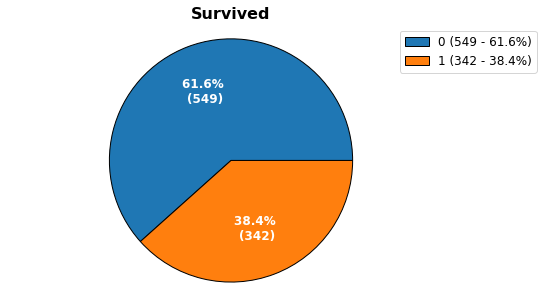

In [22]:
df_Survived  = percentCol(train, 'Survived')
pie_chart(df_Survived , title='Survived')

<div class="alert alert-block alert-warning">
        Balanced or imbalanced?
</div>

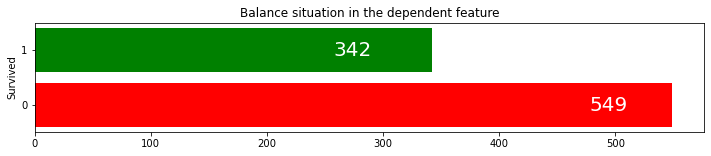

In [23]:
balanceOrInbalance(df_Survived)

- The difference between 0 and 1 values in the dependent feature is not very high. So the dataset is in balance.

<div class="alert alert-block alert-success">
    <h4>
        Pclass
    </h4>
</div>

<img src="https://i.pinimg.com/originals/dd/a4/49/dda4498b1eebd33411b4b1b5b14774d6.gif" style="height:350px">

pclass: A proxy for socio-economic status (SES)<br>
Ticket class<br>
1st = First class passengers were some of the richest and most important people of the time.<br>
2nd = Many of the second class passengers were tourists, made up of professions such as teachers and clergy.<br>
3rd = The passengers in third class were mainly immigrants heading for a new life in America. <br>




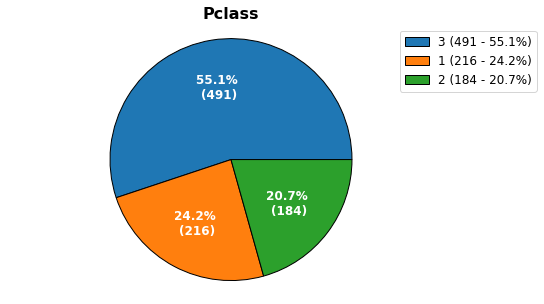

In [24]:
df_Pclass  = percentCol(train, 'Pclass')
pie_chart(df_Pclass , title='Pclass')

Survived    0    1
Pclass            
3         372  119
1          80  136
2          97   87


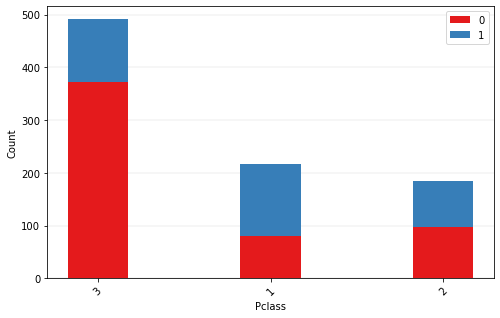

In [25]:
stacked_bar_chart(train, 'Pclass', 'Survived')

In [26]:
df_group = train.groupby(['Pclass', 'Sex'])
df_group = df_group['Survived'].value_counts().rename('count').reset_index()
df_group = df_group.sort_values(by=['Pclass', 'Sex', 'Survived'], ascending=True).reset_index(drop=True)
df_group

,Pclass,Sex,Survived,count
0,1,female,0,3
1,1,female,1,91
2,1,male,0,77
3,1,male,1,45
4,2,female,0,6
5,2,female,1,70
6,2,male,0,91
7,2,male,1,17
8,3,female,0,72
9,3,female,1,72


In [27]:
# first class
print('If a passenger was first class and female, the chance of survival was {:.1%}.'.format(91/(3+91)))
print('If a passenger was first class and male, the chance of survival was {:.1%}.'.format(45/(77+45)))
print('=====')
# second class
print('If a passenger was second class and female, the chance of survival was {:.1%}.'.format(70/(6+70)))
print('If a passenger was second class and male, the chance of survival was {:.1%}.'.format(17/(91+17)))
print('=====')
# third class
print('If a passenger was third class and female, the chance of survival was {:.1%}.'.format(72/(72+72)))
print('If a passenger was third class and male, the chance of survival was {:.1%}.'.format(47/(300+47)))

If a passenger was first class and female, the chance of survival was 96.8%.
If a passenger was first class and male, the chance of survival was 36.9%.
=====
If a passenger was second class and female, the chance of survival was 92.1%.
If a passenger was second class and male, the chance of survival was 15.7%.
=====
If a passenger was third class and female, the chance of survival was 50.0%.
If a passenger was third class and male, the chance of survival was 13.5%.


- A person who was a 1st or 2nd class passenger and a woman was much more likely to survive on the Titanic
- Women had a higher chance of survival than men. However, the chance of survival of women in Third Class passengers were half

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [28]:
train, test = one_hot_encoding(train, test, 'Pclass')

In [29]:
train.tail(3)

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,0,0,1
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,1,0,0
890,0,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,0,0,1


In [30]:
test.head(3)

,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3
0,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,1
1,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1
2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Name
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Extract titles
</div>

In [31]:
def group_titles(df):
    # find titles
    import re
    title = []
    for i in df['Name']:
        title.append(re.search('([A-Z][a-z]+)\.',i)[1])

    # create a column named 'Title'
    df["Title"] = title

    # the titles are grouped according to whether they survived or not.
    special_title = ['Mlle', 'Ms', 'Mme', 'Countess', 'Sir', 'Lady', 'Major', 'Col']
    ordinary_title = ['Dr', 'Rev', 'Capt', 'Don', 'Jonkheer']

    # rename each item in Title column if they are in the grouped lists above
    for ind, title in enumerate(df['Title']):
        if title in special_title:
            df.loc[ind,'Title'] = 'special'
        elif title in ordinary_title:
            df.loc[ind,'Title'] = 'ordinary'
        elif title == 'Dona':
            df.loc[ind,'Title'] = 'Mrs'
        else:
            continue
            
    return df

Survived    0    1
Title             
Mr        436   81
Miss       55  127
Mrs        26   99
Master     17   23
ordinary   13    3
special     2    9


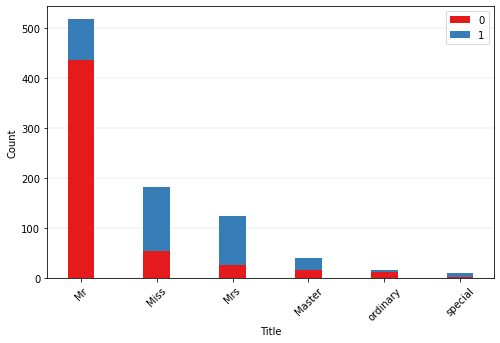

In [32]:
train = group_titles(train)
stacked_bar_chart(train, 'Title', 'Survived')

In [33]:
df_group = train.groupby(['Title'])
df_group = df_group['Survived'].value_counts().rename('count').reset_index()
df_group = df_group.sort_values(by=['Title', 'Survived'], ascending=True).reset_index(drop=True)
df_group

,Title,Survived,count
0,Master,0,17
1,Master,1,23
2,Miss,0,55
3,Miss,1,127
4,Mr,0,436
5,Mr,1,81
6,Mrs,0,26
7,Mrs,1,99
8,ordinary,0,13
9,ordinary,1,3


In [34]:
print('{:.1%} of Master passengers who survived.'.format(23/(17+23)))
print('{:.1%} of Miss passengers who survived.'.format(127/(55+127)))
print('{:.1%} of Mr passengers who survived.'.format(81/(436+81)))
print('{:.1%} of Mrs passengers who survived.'.format(99/(26+99)))
print('{:.1%} of Ordinary passengers who survived.'.format(3/(13+3)))
print('{:.1%} of Special passengers who survived.'.format(9/(2+9)))

57.5% of Master passengers who survived.
69.8% of Miss passengers who survived.
15.7% of Mr passengers who survived.
79.2% of Mrs passengers who survived.
18.8% of Ordinary passengers who survived.
81.8% of Special passengers who survived.


In [35]:
print('{:.1%} of the passengers who dead was Mr.'.format(436/(17+55+436+26+13+2)))

79.4% of the passengers who dead was Mr.


In [36]:
train.groupby(['Title', 'Survived']).sum()[['Pclass_1', 'Pclass_2', 'Pclass_3']].iloc[4:6,:]

Pclass_1  Pclass_2  Pclass_3
Title Survived                              
Mr    0               70        83       283
      1               37         8        36

In [37]:
print('{:.1%} of Mr passengers who died was Third Class passengers.'.format(283/(70+83+283)))

64.9% of Mr passengers who died was Third Class passengers.


In [38]:
test = group_titles(test)

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [39]:
train, test = one_hot_encoding(train, test, 'Title')

In [40]:
train.tail(3)

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,0,0,1,0,1,0,0,0,0
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,1,0,0,0,0,1,0,0,0
890,0,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,0,0,1,0,0,1,0,0,0


In [41]:
test.head(3)

,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special
0,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,1,0,0,1,0,0,0
1,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,0,0,0,1,0,0
2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,0,1,0,0,0


<div class="alert alert-block alert-warning">
        Extract surnames
</div>

Analyze whether the people from the same family survived or died

In [42]:
import re
from sklearn.preprocessing import MinMaxScaler

def find_surnames(df):
    surname = []
    for i in df['Name']:
        surname.append(re.search('^(.+?),',i)[1])

    # create a column named 'Surname'
    df["Surname"] = surname
    df = encode_categorical_column(df, "Surname")
    
    return df
    
def find_surnames_and_normalize(train, test):
    train = find_surnames(train)
    test = find_surnames(test)

    # Normalization -> rescaling of the column to the range 0-1
    train_for_scaler = train[['Surname']]
    test_for_scaler = test[['Surname']]
    
    scaler = MinMaxScaler()
    scaler.fit(train_for_scaler)
    
    train_scaled = scaler.transform(train_for_scaler)
    test_scaled = scaler.transform(test_for_scaler)
    
    train["Surname"] = train_scaled
    test["Surname"] = test_scaled

    return train, test

In [43]:
train, test = find_surnames_and_normalize(train, test)

In [44]:
train.tail(3)

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,0,0,1,0,1,0,0,0,0,0.196697
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,1,0,0,0,0,1,0,0,0,0.433934
890,0,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,0,0,1,0,0,1,0,0,0,1.000000


In [45]:
test.head(3)

,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname
0,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,1,0,0,1,0,0,0,0.294294
1,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,0,0,0,1,0,0,0.466967
2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,0,1,0,0,0,0.381381


<div class="alert alert-block alert-warning">
        Name Type
</div>

In [46]:
def name_type(df):
    name_type = []
    for i in df['Name']:
        if re.search('(\([A-Z][a-z].+\))',i):
            name_type.append('double')
        else:
            name_type.append('single')

    # create a column named 'NameType'
    df["NameType"] = name_type
    
    return df

In [47]:
train = name_type(train)
test = name_type(test)

Survived    0    1
NameType          
single    521  243
double     28   99


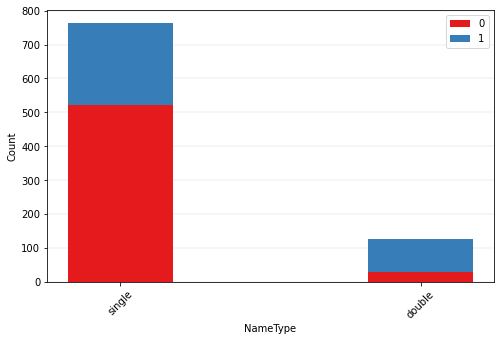

In [48]:
stacked_bar_chart(train, 'NameType', 'Survived')

In [49]:
df_group = train.groupby(['NameType'])
df_group = df_group['Survived'].value_counts().rename('count').reset_index()
df_group = df_group.sort_values(by=['NameType', 'Survived'], ascending=True).reset_index(drop=True)
df_group

,NameType,Survived,count
0,double,0,28
1,double,1,99
2,single,0,521
3,single,1,243


In [50]:
print('{:.1%} of Single Name passengers who survived.'.format(243/(521+243)))
print('{:.1%} of Double Name passengers who survived.'.format(99/(28+99)))

31.8% of Single Name passengers who survived.
78.0% of Double Name passengers who survived.


In [51]:
df_group = train.groupby(['NameType', 'Sex'])
df_group = df_group['Survived'].value_counts().rename('count').reset_index()
df_group = df_group.sort_values(by=['NameType', 'Sex', 'Survived'], ascending=True).reset_index(drop=True)
df_group

,NameType,Sex,Survived,count
0,double,female,0,27
1,double,female,1,98
2,double,male,0,1
3,double,male,1,1
4,single,female,0,54
5,single,female,1,135
6,single,male,0,467
7,single,male,1,108


- The most of Double Name passengers were women. Therefore, Double Name passengers had a higher survival rate.

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [52]:
train, test = one_hot_encoding(train, test, 'NameType')

In [53]:
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [54]:
train.tail(3)

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single
888,0,female,NaN,1,2,W./C. 6607,23.45,NaN,S,0,0,1,0,1,0,0,0,0,0.196697,0,1
889,1,male,26.0,0,0,111369,30.00,C148,C,1,0,0,0,0,1,0,0,0,0.433934,0,1
890,0,male,32.0,0,0,370376,7.75,NaN,Q,0,0,1,0,0,1,0,0,0,1.000000,0,1


In [55]:
test.head(3)

,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single
0,male,34.5,0,0,330911,7.8292,NaN,Q,0,0,1,0,0,1,0,0,0,0.294294,0,1
1,female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,0,0,0,1,0,0,0.466967,1,0
2,male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,0,1,0,0,0,0.381381,0,1


<div class="alert alert-block alert-success">
    <h4>
        SibSp & Parch
    </h4>
</div>

SibSp: Number of siblings / spouses aboard the Titanic<br>
Parch: Number of parents / children aboard the Titanic<br>

SibSp & Parch will be evaluated together and the new feature will show us if a person is alone or has relatives. 

Survived         0      1
Family_Size              
1            374.0  163.0
2             72.0   89.0
3             43.0   59.0
4              8.0   21.0
6             19.0    3.0
5             12.0    3.0
7              8.0    4.0
11             7.0    0.0
8              6.0    0.0


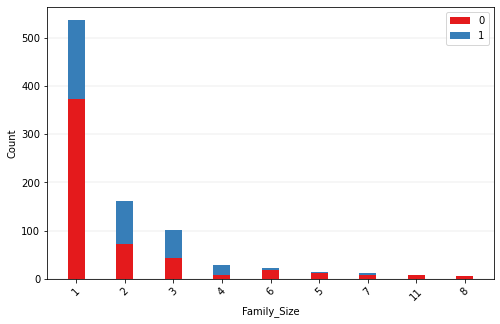

In [56]:
# including the passenger himself/herself has also been added
train['Family_Size'] = train['SibSp'] + train['Parch'] + 1

stacked_bar_chart(train, 'Family_Size', 'Survived')

In [57]:
df_group = train.groupby(['Family_Size'])
df_group = df_group['Survived'].value_counts().rename('count').reset_index()
df_group = df_group.sort_values(by=['Family_Size', 'Survived'], 
                                ascending=True).reset_index(drop=True)
df_group

,Family_Size,Survived,count
0,1,0,374
1,1,1,163
2,2,0,72
3,2,1,89
4,3,0,43
5,3,1,59
6,4,0,8
7,4,1,21
8,5,0,12
9,5,1,3


In [58]:
print('{:.1%} of Family_Size=1 who survived.'.format(163/(374+163)))
print('{:.1%} of Family_Size=2 who survived.'.format(89/(72+89)))
print('{:.1%} of Family_Size=3 who survived.'.format(59/(43+59)))
print('{:.1%} of Family_Size=4 who survived.'.format(21/(8+21)))
print('{:.1%} of Family_Size more than 4 who survived.'.format((3+3+4)/(3+3+4+12+19+8+6+7)))

30.4% of Family_Size=1 who survived.
55.3% of Family_Size=2 who survived.
57.8% of Family_Size=3 who survived.
72.4% of Family_Size=4 who survived.
16.1% of Family_Size more than 4 who survived.


In [59]:
df_group = train.groupby(['Family_Size', 'Sex'])
df_group = df_group['Survived'].value_counts().rename('count').reset_index()
df_group = df_group.sort_values(by=['Family_Size', 'count'], 
                                ascending=[True, False]).reset_index(drop=True)
df_group.iloc[0:6, :]

,Family_Size,Sex,Survived,count
0,1,male,0,347
1,1,female,1,99
2,1,male,1,64
3,1,female,0,27
4,2,female,1,71
5,2,male,0,56


In [60]:
print('{:.1%} of the passengers who were alone on the ship were men. Therefore, the mortality rate in '\
      'this group is high.'.format((347+64)/(347+64+27+99)))

76.5% of the passengers who were alone on the ship were men. Therefore, the mortality rate in this group is high.


In [61]:
df_group.iloc[4:16, :]

,Family_Size,Sex,Survived,count
4,2,female,1,71
5,2,male,0,56
6,2,male,1,18
7,2,female,0,16
8,3,female,1,38
9,3,male,0,32
10,3,male,1,21
11,3,female,0,11
12,4,female,1,16
13,4,male,0,5


- In families with 2, 3 and 4 people, men preferred to sacrifice themselves for their families

In [62]:
train.groupby(['Family_Size']).sum().loc[:, ['Pclass_1', 'Pclass_2', 'Pclass_3']].loc[5:, :]

,Pclass_1,Pclass_2,Pclass_3
Family_Size,,,
5,2,1,12
6,4,1,17
7,0,0,12
8,0,0,6
11,0,0,7


- Families with more than 4 people were less likely to survive as they mostly had 3rd class tickets.

In [63]:
# group sizes larger than 4
for ind, size in enumerate(train['Family_Size']):
    if size > 4:
        train.loc[ind, 'Family_Size'] = 5

In [64]:
# including the passenger himself/herself has also been added
test['Family_Size'] = test['SibSp'] + test['Parch'] + 1

# group sizes larger than 4
for ind, size in enumerate(test['Family_Size']):
    if size > 4:
        test.loc[ind, 'Family_Size'] = 5

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [65]:
train, test = one_hot_encoding(train, test, 'Family_Size')
train, test = one_hot_encoding(train, test, 'SibSp')
train, test = one_hot_encoding(train, test, 'Parch')

In [66]:
train.tail(3)

,Survived,Sex,Age,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
888,0,female,NaN,W./C. 6607,23.45,NaN,S,0,0,1,0,1,0,0,0,0,0.196697,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
889,1,male,26.0,111369,30.00,C148,C,1,0,0,0,0,1,0,0,0,0.433934,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
890,0,male,32.0,370376,7.75,NaN,Q,0,0,1,0,0,1,0,0,0,1.000000,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [67]:
test.head(3)

,Sex,Age,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,male,34.5,330911,7.8292,NaN,Q,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,female,47.0,363272,7.0000,NaN,S,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,male,62.0,240276,9.6875,NaN,Q,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


<div class="alert alert-block alert-success">
    <h4>
        Ticket
    </h4>
</div>

<img src="https://i.pinimg.com/564x/f0/e3/7e/f0e37e285cb14ecd3ea426c061db9aa3.jpg" style="height:200px">

In [68]:
def ticket_number_info(df, col):
    ticket_type = []
    ticket_num_len = []
    for i in df[col]:
        # split letters and numbers from ticket number
        splitted = i.split(' ')
        # if the ticket number does not have any letter, fill as 'no_type'
        if len(splitted)==1:
            ticket_type.append('no_type')
            ticket_num_len.append(len(splitted[0].strip()))
        elif len(splitted)==2:
            ticket_type.append(splitted[0].strip())
            ticket_num_len.append(len(splitted[1]))
        elif len(splitted)==3:
            ticket_type.append((''.join(splitted[0:2]).strip()))
            ticket_num_len.append(len(splitted[2].strip()))
        else:
            print(i)
    # create new columns named 'Ticket_type' and 'Ticket_num_len'
    df['Ticket_type'] = ticket_type
    df['Ticket_num_len'] = ticket_num_len

    # change the item to 3 if the ticket number length is less than 4
    for ind, num in enumerate(df['Ticket_num_len']):
        if num < 4:
            df.loc[ind, 'Ticket_num_len'] = 3
            
    return df

In [69]:
train = ticket_number_info(train, 'Ticket')

Survived          0    1
Ticket_num_len          
6               288  135
5               107  139
4               116   53
7                32   12
3                 6    3


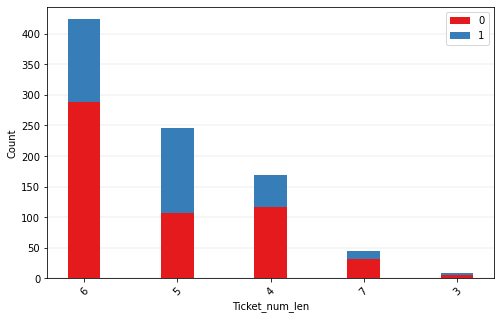

In [70]:
stacked_bar_chart(train, 'Ticket_num_len', 'Survived')

<div class="alert alert-block alert-warning">
        Encoding & KBinsDiscretizer
</div>

Survived       0    1
Ticket_type          
0            530  333
1             19    9


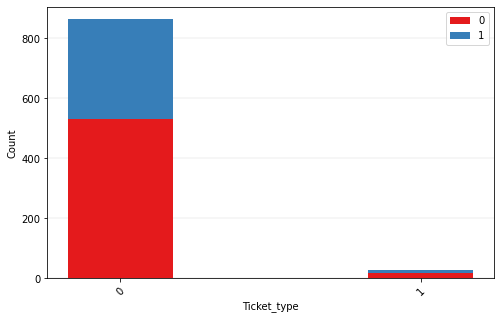

In [71]:
encode_categorical_column(train, 'Ticket_type')
train = k_bins_discretizer(train, 'Ticket_type', 2, 'uniform')
stacked_bar_chart(train, 'Ticket_type', 'Survived')

In [72]:
test = ticket_number_info(test, 'Ticket')
encode_categorical_column(test, 'Ticket_type')
test = k_bins_discretizer(test, 'Ticket_type', 2, 'uniform')

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [73]:
train, test = one_hot_encoding(train, test, 'Ticket_num_len')
train, test = one_hot_encoding(train, test, 'Ticket_type')
train.drop('Ticket', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True)

In [74]:
train.tail(3)

,Survived,Sex,Age,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1
888,0,female,NaN,23.45,NaN,S,0,0,1,0,1,0,0,0,0,0.196697,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
889,1,male,26.0,30.00,C148,C,1,0,0,0,0,1,0,0,0,0.433934,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
890,0,male,32.0,7.75,NaN,Q,0,0,1,0,0,1,0,0,0,1.000000,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0


In [75]:
test.head(3)

,Sex,Age,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1
0,male,34.5,7.8292,NaN,Q,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1,female,47.0,7.0000,NaN,S,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
2,male,62.0,9.6875,NaN,Q,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Cabin
    </h4>
</div>

In [76]:
import re

def extract_cabin_class(df, col):
    cabin_class = []
    for i in df[col]:
        if i != 'unknown':
            # get the first letter of the Cabin Number
            cabin_class.append(re.search('^(\w)',i)[1])
        else:
            # if the Cabin Number is unknown, fill as 'U'
            cabin_class.append('U')
            
    # create a column named 'Cabin_class'
    df["Cabin_class"] = cabin_class
    df.drop(['Cabin'], axis=1, inplace=True)
    
    return df

In [77]:
train['Cabin'].fillna('unknown', inplace=True)
train = extract_cabin_class(train, 'Cabin')

Survived         0      1
Cabin_class              
U            481.0  206.0
C             24.0   35.0
B             12.0   35.0
D              8.0   25.0
E              8.0   24.0
A              8.0    7.0
F              5.0    8.0
G              2.0    2.0
T              1.0    0.0


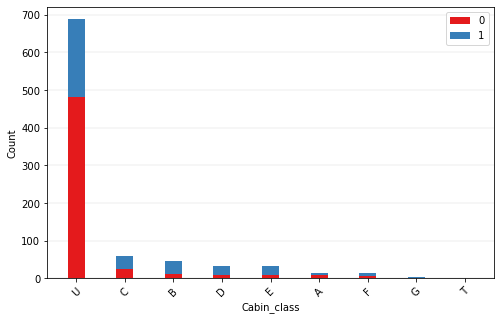

In [78]:
stacked_bar_chart(train, 'Cabin_class', 'Survived')

- A, B Deck, also called the Promenade Deck, It was reserved exclusively for First Class passengers
- C, D Deck, the Saloon Deck, First, Second and Third Class passengers had cabins on this deck
- E Deck, the Upper Deck, was predominantly used for passenger accommodation for all three classes
- F Deck, the Middle Deck, mainly accommodated Second and Third Class passengers and several departments of the crew.
- G Deck, the Lower Deck, was the lowest complete deck that carried passengers, and had the lowest portholes, just above the waterline. 

In [79]:
train.groupby(['Cabin_class', 'Survived']).sum().loc['U', ['Pclass_1', 'Pclass_2', 'Pclass_3']]

,Pclass_1,Pclass_2,Pclass_3
Survived,,,
0,21,94,366
1,19,74,113


In [80]:
print('{:.1%} of the passengers whose cabin classes were unknown and who died were Third Class passengers.' \
      'Of course, most of them were men.'.format((366)/(21+94+366)))

76.1% of the passengers whose cabin classes were unknown and who died were Third Class passengers.Of course, most of them were men.


In [81]:
test['Cabin'].fillna('unknown', inplace=True)
test = extract_cabin_class(test, 'Cabin')

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [82]:
train, test = one_hot_encoding(train, test, 'Cabin_class')

In [83]:
train.tail(3)

,Survived,Sex,Age,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U
888,0,female,NaN,23.45,S,0,0,1,0,1,0,0,0,0,0.196697,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
889,1,male,26.0,30.00,C,1,0,0,0,0,1,0,0,0,0.433934,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
890,0,male,32.0,7.75,Q,0,0,1,0,0,1,0,0,0,1.000000,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1


In [84]:
test.head(3)

,Sex,Age,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U
0,male,34.5,7.8292,Q,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
1,female,47.0,7.0000,S,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
2,male,62.0,9.6875,Q,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1


<div class="alert alert-block alert-success">
    <h4>
        Sex
    </h4>
</div>

Survived    0    1
Sex               
male      468  109
female     81  233


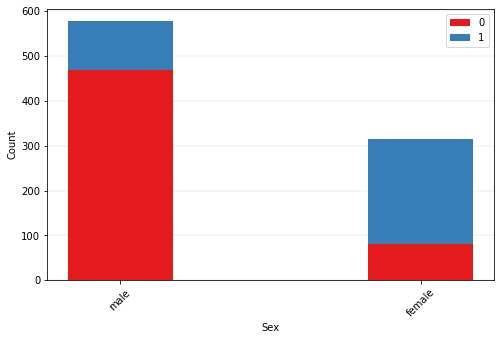

In [85]:
stacked_bar_chart(train, 'Sex', 'Survived')

In [86]:
df_group = train.groupby(['Sex'])
df_group = df_group['Survived'].value_counts().rename('count').reset_index()
df_group = df_group.sort_values(by=['Sex', 'Survived'], 
                                ascending=True).reset_index(drop=True)
df_group

,Sex,Survived,count
0,female,0,81
1,female,1,233
2,male,0,468
3,male,1,109


In [87]:
print('{:.1%} of male passengers who survived.'.format((109)/(468+109)))
print('{:.1%} of female passengers who survived.'.format((233)/(81+233)))

18.9% of male passengers who survived.
74.2% of female passengers who survived.


In [88]:
train.groupby(['Sex', 'Survived']).sum().loc['male', ['Pclass_1', 'Pclass_2', 'Pclass_3']]

,Pclass_1,Pclass_2,Pclass_3
Survived,,,
0,77,91,300
1,45,17,47


In [89]:
print('{:.1%} of male passengers who died were Third Class passengers.'.format(300/(77+91+300)))

64.1% of male passengers who died were Third Class passengers.


<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [90]:
train, test = one_hot_encoding(train, test, 'Sex')

In [91]:
train.tail(3)

,Survived,Age,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male
888,0,NaN,23.45,S,0,0,1,0,1,0,0,0,0,0.196697,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
889,1,26.0,30.00,C,1,0,0,0,0,1,0,0,0,0.433934,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1
890,0,32.0,7.75,Q,0,0,1,0,0,1,0,0,0,1.000000,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1


In [92]:
test.head(3)

,Age,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male
0,34.5,7.8292,Q,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1
1,47.0,7.0000,S,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0
2,62.0,9.6875,Q,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1


<div class="alert alert-block alert-success">
    <h4>
        Embarked
    </h4>
</div>

Port of Embarkation<br>
C = Cherbourg, Q = Queenstown, S = Southampton

In [93]:
train[train['Embarked'].isna()]

,Survived,Age,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male
61,1,38.0,80.0,NaN,1,0,0,0,1,0,0,0,0,0.753754,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
829,1,62.0,80.0,NaN,1,0,0,0,0,0,1,0,0,0.381381,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0


<div class="alert alert-block alert-warning">
        Missing Values
</div>

In [94]:
# train[(train['Cabin_class']=='B') & (train['Fare_cat']==5) & (train['Ticket_num_len']==6) & 
# (train['Family_Size']==0)]
train[(train['Survived']==1) & (train['Family_Size_1']==1) & (train['Cabin_class_B']==1) & 
      (train['Sex_female']==1) & (train['Ticket_num_len_5']==0) & (train['Ticket_num_len_6']==1)]

,Survived,Age,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male
61,1,38.0,80.0,NaN,1,0,0,0,1,0,0,0,0,0.753754,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
257,1,30.0,86.5,S,1,0,0,0,1,0,0,0,0,0.929429,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
504,1,16.0,86.5,S,1,0,0,0,1,0,0,0,0,0.324324,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
759,1,33.0,86.5,S,1,0,0,0,0,0,0,0,1,0.546547,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
829,1,62.0,80.0,NaN,1,0,0,0,0,0,1,0,0,0.381381,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
887,1,19.0,30.0,S,1,0,0,0,1,0,0,0,0,0.058559,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0


In [95]:
for ind in train[train['Embarked'].isna()].index:
    train.loc[ind, 'Embarked'] = 'S'

Survived    0    1
Embarked          
S         427  219
C          75   93
Q          47   30


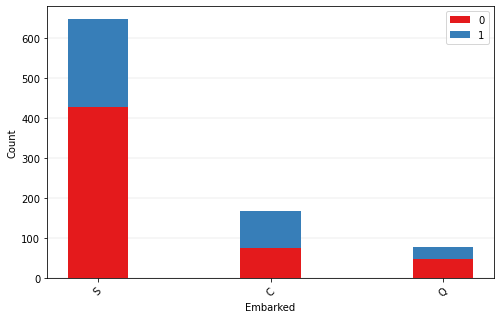

In [96]:
stacked_bar_chart(train, 'Embarked', 'Survived')

In [97]:
df_group = train.groupby(['Embarked'])
df_group = df_group['Survived'].value_counts().rename('count').reset_index()
df_group = df_group.sort_values(by=['Embarked', 'Survived'], 
                                ascending=True).reset_index(drop=True)
df_group

,Embarked,Survived,count
0,C,0,75
1,C,1,93
2,Q,0,47
3,Q,1,30
4,S,0,427
5,S,1,219


In [98]:
print('{:.1%} of passengers boarded the Titanic in the Port of Cherbourg.'.format((75+93)/len(train)))
print('{:.1%} of passengers boarded the Titanic in the Port of Queenstown.'.format((47+30)/len(train)))
print('{:.1%} of passengers boarded the Titanic in the Port of Southampton.'.format((427+219)/len(train)))

18.9% of passengers boarded the Titanic in the Port of Cherbourg.
8.6% of passengers boarded the Titanic in the Port of Queenstown.
72.5% of passengers boarded the Titanic in the Port of Southampton.


In [99]:
train.groupby(['Embarked', 'Survived']).sum().loc[:, ['Pclass_1', 'Pclass_2', 'Pclass_3']]

Pclass_1  Pclass_2  Pclass_3
Embarked Survived                              
C        0               26         8        41
         1               59         9        25
Q        0                1         1        45
         1                1         2        27
S        0               53        88       286
         1               76        76        67

In [100]:
# from the Port of Cherbourg
print('{:.1%} of passengers had 1.st or 2.nd Class Ticket.'.format((26+8+59+9)/(26+8+59+9+41+25)))
print('=====')
# from the Port of Queenstown
print('{:.1%} of passengers had 3.st Class Ticket.'.format((45+27)/(1+1+1+2+45+27)))
print('=====')
# from the Port of Southampton
print('{:.1%} of passengers had 3.st Class Ticket.'.format((286+67)/(53+88+76+76+286+67)))

60.7% of passengers had 1.st or 2.nd Class Ticket.
=====
93.5% of passengers had 3.st Class Ticket.
=====
54.6% of passengers had 3.st Class Ticket.


- These rates give us information about the economic conditions in the cities.

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [101]:
train, test = one_hot_encoding(train, test, 'Embarked')

In [102]:
train.tail(3)

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
888,0,NaN,23.45,0,0,1,0,1,0,0,0,0,0.196697,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
889,1,26.0,30.00,1,0,0,0,0,1,0,0,0,0.433934,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
890,0,32.0,7.75,0,0,1,0,0,1,0,0,0,1.000000,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


In [103]:
test.head(3)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,34.5,7.8292,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
1,47.0,7.0000,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
2,62.0,9.6875,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Age
    </h4>
</div>

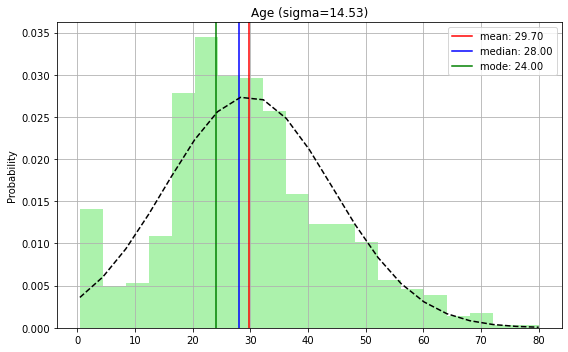

In [104]:
histogram(train, "Age")

In [105]:
print(f"min. Age: {train['Age'].min()}, \nmax. Age: {train['Age'].max()}")

min. Age: 0.42, 
max. Age: 80.0


<div class="alert alert-block alert-warning">
        Imputing Missing Values
</div>

In [106]:
train, test = imputing_missing_values(train, test, 'Age',  ['Survived', 'Fare'])

<div class="alert alert-block alert-warning">
        Categorize the feature
</div>

In [107]:
bins = [train['Age'].min()-1,20,30,40,50,60,70, train['Age'].max()+1]
labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

# Categorize the 'Age' column with the labels and bins and create a new column in the train dataframe
train['AgeGrb'] = pd.cut(train['Age'], bins=bins, labels=labels)
train['AgeGrb'] = train['AgeGrb'].cat.add_categories('unknown').fillna('unknown')
train.drop("Age", axis=1, inplace=True)

test['AgeGrb'] = pd.cut(test['Age'], bins=bins, labels=labels)
test['AgeGrb'] = test['AgeGrb'].cat.add_categories('unknown').fillna('unknown')
test.drop("Age", axis=1, inplace=True)

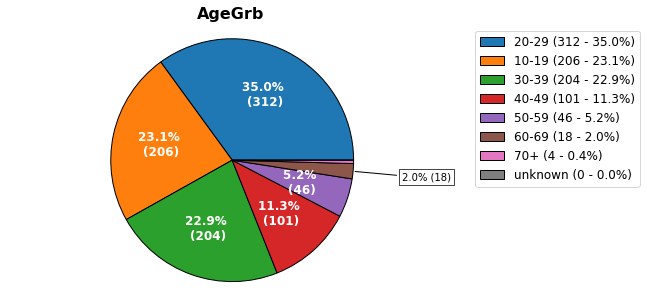

In [108]:
df_AgeGrb = percentCol(train, 'AgeGrb')
pie_chart(df_AgeGrb, title='AgeGrb', legend_pos=(1.03, 0, 0.4, 1))

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [109]:
train, test = one_hot_encoding(train, test, 'AgeGrb')

In [110]:
train.head(3)

,Survived,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,AgeGrb_10-19,AgeGrb_20-29,AgeGrb_30-39,AgeGrb_40-49,AgeGrb_50-59,AgeGrb_60-69,AgeGrb_70+
0,0,7.2500,0,0,1,0,0,1,0,0,0,0.147147,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0
1,1,71.2833,1,0,0,0,0,0,1,0,0,0.807808,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
2,1,7.9250,0,0,1,0,1,0,0,0,0,0.735736,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0


In [111]:
test.head(3)

,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,AgeGrb_10-19,AgeGrb_20-29,AgeGrb_30-39,AgeGrb_40-49,AgeGrb_50-59,AgeGrb_60-69,AgeGrb_70+
0,7.8292,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0
1,7.0000,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0
2,9.6875,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Fare
    </h4>
</div>

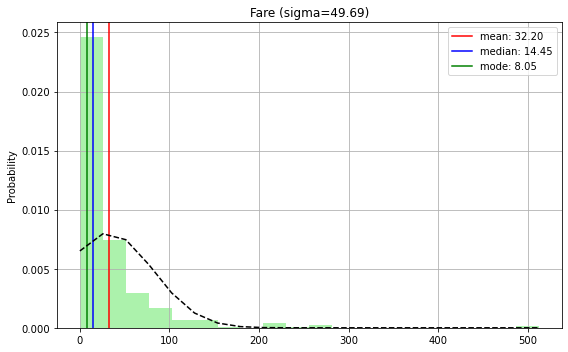

In [112]:
histogram(train, "Fare")

In [113]:
print(f"min. Fare: {train['Fare'].min()}, \nmax. Fare: {train['Fare'].max()}")

min. Fare: 0.0, 
max. Fare: 512.3292


<div class="alert alert-block alert-warning">
        Imputing Missing Values
</div>

In [114]:
train, test = imputing_missing_values(train, test, 'Fare',  ['Survived'])

<div class="alert alert-block alert-warning">
        Drop Outliers
</div>

In [115]:
test['Fare'].max()

512

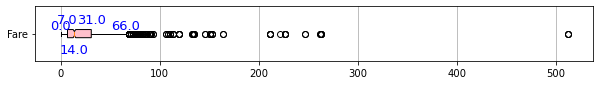

In [116]:
box_plot(train['Fare'], 'Fare')

In [117]:
outliers_index_age = train[train['Fare'] > test['Fare'].max()].index
print(outliers_index_age)

Int64Index([], dtype='int64')


<div class="alert alert-block alert-warning">
        Min-Max Scaler
</div>

In [118]:
train, test = featureScaler("minMax", train, 'Fare', test)

In [119]:
train.tail(3)

,Survived,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,AgeGrb_10-19,AgeGrb_20-29,AgeGrb_30-39,AgeGrb_40-49,AgeGrb_50-59,AgeGrb_60-69,AgeGrb_70+
888,0,0.044922,0,0,1,0,1,0,0,0,0,0.196697,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0
889,1,0.058594,1,0,0,0,0,1,0,0,0,0.433934,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0
890,0,0.013672,0,0,1,0,0,1,0,0,0,1.000000,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0


In [120]:
test.head(3)

,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_ordinary,Title_special,Surname,NameType_double,NameType_single,Family_Size_1,Family_Size_2,Family_Size_3,Family_Size_4,Family_Size_5,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Ticket_num_len_3,Ticket_num_len_4,Ticket_num_len_5,Ticket_num_len_6,Ticket_num_len_7,Ticket_type_0,Ticket_type_1,Cabin_class_A,Cabin_class_B,Cabin_class_C,Cabin_class_D,Cabin_class_E,Cabin_class_F,Cabin_class_G,Cabin_class_T,Cabin_class_U,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,AgeGrb_10-19,AgeGrb_20-29,AgeGrb_30-39,AgeGrb_40-49,AgeGrb_50-59,AgeGrb_60-69,AgeGrb_70+
0,0.013672,0,0,1,0,0,1,0,0,0,0.294294,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0
1,0.013672,0,0,1,0,0,0,1,0,0,0.466967,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0
2,0.017578,0,1,0,0,0,1,0,0,0,0.381381,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0


<a id='5.0'></a>
<div class="alert alert-block alert-danger">
<h2>Machine Learning Algorithms and Results</h2>
</div>

<a id='5.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Feature engineering
   </h3>
</div>

In [121]:
X = train.drop(['Survived'], axis=1)
y = train['Survived']

X_kaggle = test

print(X.shape)
print(X_kaggle.shape)

(891, 60)
(418, 60)


<div class="alert alert-block alert-success">
    <h4>
        Check categorical columns
    </h4>
</div>

In [122]:
categorical_feature_cols = list(set(X.columns) - set(X._get_numeric_data().columns))
categorical_feature_cols

[]

- There is no categorical columns in the dataframe

In [123]:
numerical_feature_cols = list(X._get_numeric_data().columns)
print(numerical_feature_cols)

['Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_ordinary', 'Title_special', 'Surname', 'NameType_double', 'NameType_single', 'Family_Size_1', 'Family_Size_2', 'Family_Size_3', 'Family_Size_4', 'Family_Size_5', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Ticket_num_len_3', 'Ticket_num_len_4', 'Ticket_num_len_5', 'Ticket_num_len_6', 'Ticket_num_len_7', 'Ticket_type_0', 'Ticket_type_1', 'Cabin_class_A', 'Cabin_class_B', 'Cabin_class_C', 'Cabin_class_D', 'Cabin_class_E', 'Cabin_class_F', 'Cabin_class_G', 'Cabin_class_T', 'Cabin_class_U', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'AgeGrb_10-19', 'AgeGrb_20-29', 'AgeGrb_30-39', 'AgeGrb_40-49', 'AgeGrb_50-59', 'AgeGrb_60-69', 'AgeGrb_70+']


<div class="alert alert-block alert-success">
    <h4>
        Constant and quasi constant features removal
    </h4>
</div>

- Constant: remove the features that have the same value in all samples
- Quasi constant : remove the features that they have the 99% same value 

<div class="alert alert-block alert-warning">
        Constant
</div>

In [124]:
from sklearn.feature_selection import VarianceThreshold
constant=VarianceThreshold(threshold=0)
constant.fit(X)

constant_columns = [column for column in X.columns
                    if column not in X.columns[constant.get_support()]]
print(len(constant_columns))

0


<div class="alert alert-block alert-warning">
        Quasi constant
</div>

In [125]:
# from sklearn.feature_selection import VarianceThreshold
# quasi_constant=VarianceThreshold(threshold=0.01)
# quasi_constant.fit(X)

# quasi_constant_columns = [column for column in X.columns
#                     if column not in X.columns[quasi_constant.get_support()]]
# print(quasi_constant_columns)

In [126]:
# X = pd.DataFrame(quasi_constant.transform(X), columns=X.columns[quasi_constant.get_support()])
# X_kaggle = pd.DataFrame(quasi_constant.transform(X_kaggle), 
# columns=X_kaggle.columns[quasi_constant.get_support()])

In [127]:
# X.shape, X_kaggle.shape

<div class="alert alert-block alert-success">
    <h4>
        Remove duplicate features
    </h4>
</div>

In [128]:
X_T = X.T
X_kaggle_T = X_kaggle.T

In [129]:
print(X_T.duplicated().sum(), X_kaggle_T.duplicated().sum())

0 0


- There are no dublicated features

In [130]:
# features_to_keep = [not ind for ind  in X_train_T.duplicated()]
# X_train = X_train_T[features_to_keep].T
# X_test = X_test_T[features_to_keep].T

<div class="alert alert-block alert-success">
    <h4>
        Drop highly correlated features using Pearson Correlation
    </h4>
</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png" style="height:250px">

Pearson correlation coefficient
- a measure of linear correlation between features
- the measure can only reflect a linear correlation of variables, and ignores many other types of relationship or correlation
- the result always has a value between −1 and 1

In [131]:
def highly_correlated_features(df, threshold):
    corr_matrix = df.corr()
    
    df_corr_list = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                ind_name = corr_matrix.columns[i]
                col_name = corr_matrix.columns[j]
                coeff_value_absolute = abs(corr_matrix.iloc[i, j])
                df_corr_list.append([ind_name, col_name, coeff_value_absolute])
                
    df_corr = pd.DataFrame(df_corr_list, columns=['Feature_1', 'Feature_2', 'Corr_value'])
    
    return df_corr
        
df_hcf = highly_correlated_features(train, 0.85)
df_hcf = df_hcf.sort_values(by=['Feature_1', 'Feature_2', 'Corr_value'], ascending=False)
df_hcf

,Feature_1,Feature_2,Corr_value
3,Ticket_type_1,Ticket_type_0,1.000000
5,Sex_male,Title_Mr,0.867334
6,Sex_male,Sex_female,1.000000
4,Sex_female,Title_Mr,0.867334
1,NameType_single,Title_Mrs,0.953823
2,NameType_single,NameType_double,1.000000
0,NameType_double,Title_Mrs,0.953823


<div class="alert alert-block alert-warning">
        Feature importance based on RandomForestClassifier 
</div>

- create correlated feature groups using the highly_correlated_features dataframe (df_hcf)
- only one feature will be selected from each group using RandomForestClassifier
- other features in each group will be removed

In [132]:
from sklearn.ensemble import RandomForestClassifier

# the list is used to check if each feature is in previous groups
grouped_feature_list = []
# the items in the list will be removed from the X_train and X_test
dropped_feature_list = []

for feature in df_hcf['Feature_1'].unique():
    if feature not in grouped_feature_list:
        # group the highly_correlated_features dataframe (df_hcf)
        df_feature = df_hcf[df_hcf['Feature_1'] == feature]        
        
        correlated_features_list = [feature] + list(df_feature['Feature_2'].unique())
        grouped_feature_list = grouped_feature_list + correlated_features_list

        rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
        rf.fit(train[correlated_features_list], y)
        # create an importance dataframe using the feature_importances_ values
        df_importance = pd.concat([pd.Series(correlated_features_list), pd.Series(rf.feature_importances_)], 
                               axis=1)
        df_importance.columns = ['Feature', 'Importance']
        df_importance.sort_values(by = 'Importance', ascending=False, inplace=True)
        # get the feature names except the one that has the highest improtance from the df_importance
        dropped_feature_list = dropped_feature_list + list(df_importance['Feature'][1:].values)
    
print(dropped_feature_list)  

['Ticket_type_1', 'Sex_male', 'Sex_female', 'NameType_single', 'NameType_double']


In [133]:
# drop the highly correlated features 
X = X.drop(dropped_feature_list, axis=1)
X_kaggle = X_kaggle.drop(dropped_feature_list, axis=1)

print(X.shape)
print(X_kaggle.shape)

(891, 55)
(418, 55)


<div class="alert alert-block alert-success">
    <h4>
        SelectFromModel using Logistic Regression
    </h4>
</div>

In [134]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def feature_selection(model, X_train, y_train):
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    cvs = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    acc = cvs.mean()
    
    return acc

SelectFromModel<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html?highlight=selectfrommodel#sklearn.feature_selection.SelectFromModel
- SelectFromModel can be used alongside any estimator that assigns importance to each feature through a specific attribute (such as coef_, feature_importances_). 

Parameters
- estimator: The estimator should have a feature_importances_ or coef_ attribute after fitting. Otherwise, the importance_getter parameter should be used
- threshold: “mean” is used by default

In [135]:
from sklearn.feature_selection import SelectFromModel as SFM
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs=-1)
sfm = SFM(model).fit(X, y)
cols_SFM = X.columns[sfm.get_support()].tolist()
print(cols_SFM)

acc = feature_selection(model, X, y)
acc_SFM = feature_selection(model, X[cols_SFM], y)

print('The Accuracy all features: {:.1%}'.format(acc))
print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))

['Fare', 'Pclass_1', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_ordinary', 'Surname', 'Family_Size_4', 'Family_Size_5', 'SibSp_2', 'SibSp_5', 'SibSp_8', 'Parch_3', 'Ticket_num_len_7', 'Cabin_class_D', 'Cabin_class_E', 'Cabin_class_G', 'Cabin_class_U', 'AgeGrb_10-19', 'AgeGrb_50-59', 'AgeGrb_60-69']
The Accuracy all features: 83.0%
The Accuracy selected features with SFM: 83.4%


<div class="alert alert-block alert-success">
    <h4>
        GenericUnivariateSelect and ANOVA F-value
    </h4>
</div>

In [136]:
from sklearn.feature_selection import SelectFromModel as SFM
from sklearn.linear_model import LogisticRegression

def best_features (model, X_train, y_train, cols_sel, cols_SFM, acc, acc_SFM):
    cols_model_best = []
    acc_model_best = 0
    for col in cols_sel:
        if col not in cols_SFM:
            cols_SFM = cols_SFM + [col]
            cv = KFold(n_splits=10, random_state=0, shuffle=True)
            cvs_model = cross_val_score(model, X_train[cols_SFM], y_train, scoring='accuracy', cv=cv)
            acc_model = cvs_model.mean()
            if (acc_model > acc_SFM) & (acc_model > acc_model_best):
                cols_model_best = cols_SFM
                acc_model_best = acc_model
                print(cols_model_best)
                print('The Accuracy all features: {:.1%}'.format(acc))
                print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))
                print('The Accuracy selected features with MODEL: {:.1%}'.format(acc_model_best))
                print('=====')

GenericUnivariateSelect<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html
- Univariate feature selection works by selecting the best features based on univariate statistical tests. 
- GenericUnivariateSelect allows to perform univariate feature selection with a configurable strategy. This allows to select the best univariate selection strategy with hyper-parameter search estimator.

Parameters

- score_func, default=f_classif
- mode: Feature selection mode {‘percentile’, ‘k_best’, ‘fpr’, ‘fdr’, ‘fwe’}, default=’percentile’
- param: Parameter of the corresponding mode

In [137]:
from sklearn.feature_selection import GenericUnivariateSelect as GUS
# ANOVA F-value between label/feature for classification tasks.
from sklearn.feature_selection import f_classif

gus_f = GUS(f_classif, mode='k_best', param=len(X.columns)).fit(X, y)
cols_gus_f = X.columns[gus_f.get_support()].tolist()

best_features(model, X, y, cols_gus_f, cols_SFM, acc, acc_SFM)

['Fare', 'Pclass_1', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_ordinary', 'Surname', 'Family_Size_4', 'Family_Size_5', 'SibSp_2', 'SibSp_5', 'SibSp_8', 'Parch_3', 'Ticket_num_len_7', 'Cabin_class_D', 'Cabin_class_E', 'Cabin_class_G', 'Cabin_class_U', 'AgeGrb_10-19', 'AgeGrb_50-59', 'AgeGrb_60-69', 'Pclass_2', 'Title_special', 'Family_Size_1']
The Accuracy all features: 83.0%
The Accuracy selected features with SFM: 83.4%
The Accuracy selected features with MODEL: 83.5%
=====
['Fare', 'Pclass_1', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_ordinary', 'Surname', 'Family_Size_4', 'Family_Size_5', 'SibSp_2', 'SibSp_5', 'SibSp_8', 'Parch_3', 'Ticket_num_len_7', 'Cabin_class_D', 'Cabin_class_E', 'Cabin_class_G', 'Cabin_class_U', 'AgeGrb_10-19', 'AgeGrb_50-59', 'AgeGrb_60-69', 'Pclass_2', 'Title_special', 'Family_Size_1', 'Family_Size_2', 'Family_Size_3']
The Accuracy all features: 83.0%
The Accuracy selected features with SFM: 83.

<div class="alert alert-block alert-success">
    <h4>
        SelectKBest and Mutual Information
    </h4>
</div>

SelectKBest<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html?highlight=selectkbest#sklearn.feature_selection.SelectKBest
- Univariate feature selection works by selecting the best features based on univariate statistical tests. 
- SelectKBest removes all but the  highest scoring features

Parameters

- score_func, default=f_classif
- k, default=10: Number of top features to select

In [138]:
from sklearn.feature_selection import SelectKBest
# Mutual information for a discrete target.
from sklearn.feature_selection import mutual_info_classif

# select the  top k important features
KBest_m = SelectKBest(mutual_info_classif, k=len(X.columns)).fit(X, y)
cols_KBest_m = X.columns[KBest_m.get_support()].tolist()

best_features(model, X, y, cols_KBest_m, cols_SFM, acc, acc_SFM)

['Fare', 'Pclass_1', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_ordinary', 'Surname', 'Family_Size_4', 'Family_Size_5', 'SibSp_2', 'SibSp_5', 'SibSp_8', 'Parch_3', 'Ticket_num_len_7', 'Cabin_class_D', 'Cabin_class_E', 'Cabin_class_G', 'Cabin_class_U', 'AgeGrb_10-19', 'AgeGrb_50-59', 'AgeGrb_60-69', 'Pclass_2', 'Title_special', 'Family_Size_1']
The Accuracy all features: 83.0%
The Accuracy selected features with SFM: 83.4%
The Accuracy selected features with MODEL: 83.5%
=====
['Fare', 'Pclass_1', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_ordinary', 'Surname', 'Family_Size_4', 'Family_Size_5', 'SibSp_2', 'SibSp_5', 'SibSp_8', 'Parch_3', 'Ticket_num_len_7', 'Cabin_class_D', 'Cabin_class_E', 'Cabin_class_G', 'Cabin_class_U', 'AgeGrb_10-19', 'AgeGrb_50-59', 'AgeGrb_60-69', 'Pclass_2', 'Title_special', 'Family_Size_1', 'Family_Size_2', 'Family_Size_3']
The Accuracy all features: 83.0%
The Accuracy selected features with SFM: 83.

<div class="alert alert-block alert-success">
    <h4>
        RFE (Recursive feature elimination)
    </h4>
</div>

RFE<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html?highlight=rfe#sklearn.feature_selection.RFE
- Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.

Parameters

- estimator: A supervised learning estimator with a fit method that provides information about feature importance (e.g. coef_, feature_importances_)
- n_features_to_select, default=None: Number of top features to select

In [139]:
from sklearn.feature_selection import RFE

new_cols_RFE = cols_SFM.copy()
acc_RFE_best = 0
new_cols_RFE_best = []

for i in range(10, len(X.columns)+1):
    selector = RFE(estimator=model, n_features_to_select=i).fit(X, y)
    new_cols_RFE = X.columns[selector.get_support()]
    
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    cvs_RFE = cross_val_score(model, X[new_cols_RFE], y, scoring='accuracy', cv=cv)
    acc_RFE = cvs_RFE.mean()
    
    if acc_RFE > acc_RFE_best:
        acc_RFE_best = acc_RFE
        new_cols_RFE_best = new_cols_RFE
        
        print(new_cols_RFE_best)
        print('The Accuracy all features: {:.1%}'.format(acc))
        print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))
        print('The Accuracy selected features with KBest: {:.1%}'.format(acc_RFE_best))
        print('=====')

Index(['Fare', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_ordinary', 'Family_Size_5', 'Cabin_class_D',
       'Cabin_class_E'],
      dtype='object')
The Accuracy all features: 83.0%
The Accuracy selected features with SFM: 83.4%
The Accuracy selected features with KBest: 82.7%
=====
Index(['Fare', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_ordinary', 'Family_Size_5', 'Parch_3',
       'Cabin_class_D', 'Cabin_class_E'],
      dtype='object')
The Accuracy all features: 83.0%
The Accuracy selected features with SFM: 83.4%
The Accuracy selected features with KBest: 82.9%
=====
Index(['Fare', 'Pclass_1', 'Pclass_3', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_ordinary', 'Family_Size_5', 'Parch_3',
       'Cabin_class_D', 'Cabin_class_E'],
      dtype='object')
The Accuracy all features: 83.0%
The Accuracy selected features with SFM: 83.4%
The Accuracy selected features with KBest: 83.2%
===

<a id='5.2'></a>
<div class="alert alert-block alert-info">
   <h3>
        Correlation of the features
   </h3>
</div>

In [140]:
selected_features = ['Fare', 'Pclass_1', 'Pclass_3', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_ordinary', 'Family_Size_5', 'Parch_3',
       'Ticket_num_len_7', 'Cabin_class_D', 'Cabin_class_E', 'Cabin_class_G',
       'Cabin_class_U', 'AgeGrb_10-19', 'AgeGrb_20-29', 'AgeGrb_30-39']

X = X[selected_features]
X_kaggle = X_kaggle[selected_features]

print(X.shape)
print(X_kaggle.shape)

(891, 18)
(418, 18)


In [141]:
def create_heatmap(hm, figsize=(16, 8)):
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(hm, cmap='viridis', aspect='auto')

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(hm.columns)))
    ax.set_yticks(np.arange(len(hm.columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(hm.columns)
    ax.set_yticklabels(hm.columns)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(hm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(hm.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(hm.columns)):
        for j in range(len(hm.columns)):
            hm_val = round(hm.values[i, j], 2)
            if hm_val > 0.85:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="black", size=16)
            else:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="w", size=16)

    fig.tight_layout()
    plt.show()

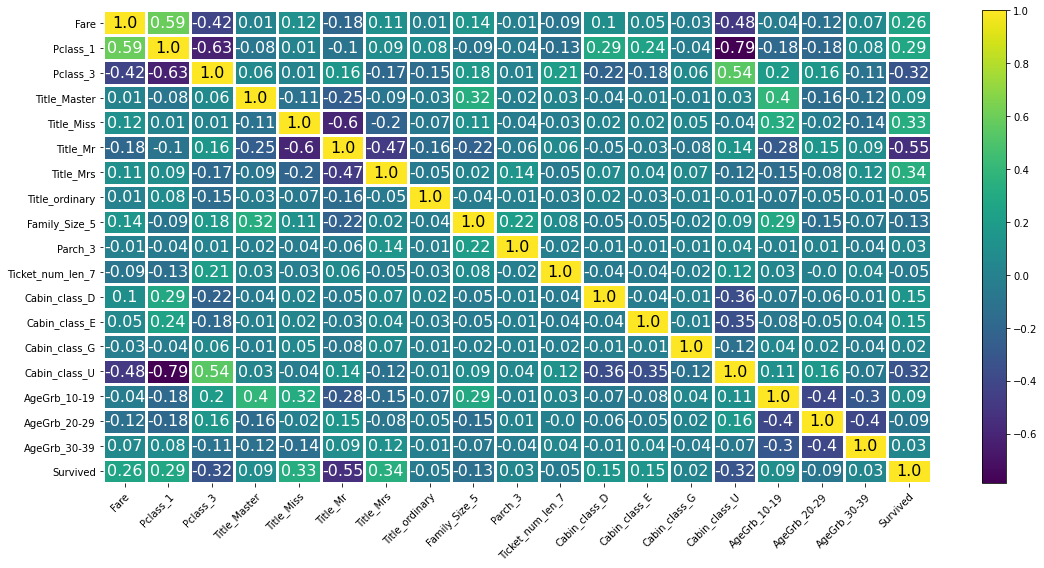

In [142]:
hm_train_new = pd.concat([X, y], axis=1).corr()
create_heatmap(hm_train_new)

In [143]:
cols_dropped = list(hm_train_new[(hm_train_new["Survived"] > -0.03)&(hm_train_new["Survived"] < 0.03)]\
                    ["Survived"].index)
print(cols_dropped)

['Cabin_class_G']


In [144]:
X.drop(cols_dropped, axis=1, inplace=True)
X_kaggle.drop(cols_dropped, axis=1, inplace=True)

<a id='5.3'></a>
<div class="alert alert-block alert-info">
   <h3>
        Split Dataframe
   </h3>
</div>

In [145]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.30, random_state=0)

print(X_train.shape)
print(X_test.shape)

(623, 17)
(268, 17)


<a id='5.4'></a>
<div class="alert alert-block alert-info">
   <h3>
        Overcoming Class Imbalance using SMOTE
   </h3>
</div>

- It is an imbalanced data where the target variable
- SMOTE: Synthetic Minority Oversampling Technique will be used for creating synthesized data
- A comparative analysis will be done on the dataset using RandomForestClassifier
- The accuracy metric will be ignored to evaluate the performance of the classifier on this imbalanced dataset
- Precision, recall, F1-score metrics will be taken into account 

<div class="alert alert-block alert-warning">
        SMOTE: Synthetic Minority Oversampling Technique
</div>

- SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.
- Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

<img src="https://editor.analyticsvidhya.com/uploads/64068image3.png" style="height:250px">

In [146]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', n_jobs=-1)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [147]:
df_Survived_smote = percentCol(pd.concat([X_train_sm, y_train_sm], axis=1), 'Survived')

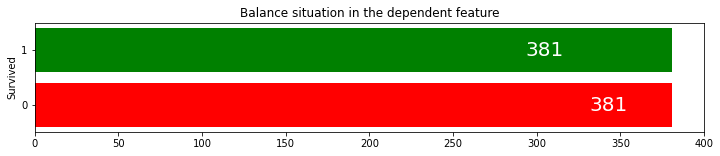

In [148]:
balanceOrInbalance(df_Survived_smote)

<div class="alert alert-block alert-success">
    <h4>
        Comparison
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Before
</div>

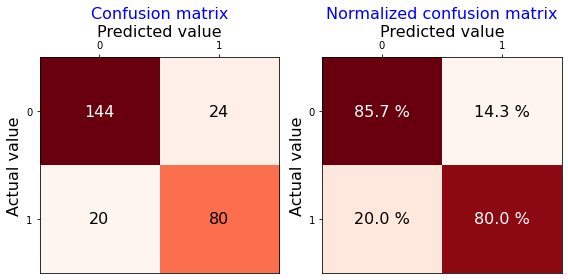

In [149]:
from sklearn.linear_model import LogisticRegression

params = {}
log = LogisticRegression()
log_cm_metrics, log_pred = evaluate_model(log, X_train, y_train, X_test, y_test, params)

<div class="alert alert-block alert-warning">
        After
</div>

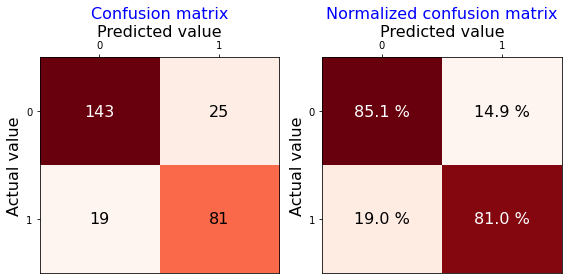

In [150]:
from sklearn.linear_model import LogisticRegression

params = {}
log = LogisticRegression()
log_cm_metrics, log_pred = evaluate_model(log, X_train_sm, y_train_sm, X_test, y_test, params)

- There is an increase in some metrics, especially in TPR

<a id='4.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Building ML models
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Logistic
    </h4>
</div>

<img src="https://static.javatpoint.com/tutorial/machine-learning/images/logistic-regression-in-machine-learning.png" style="height:150px">

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

best prarams: {}


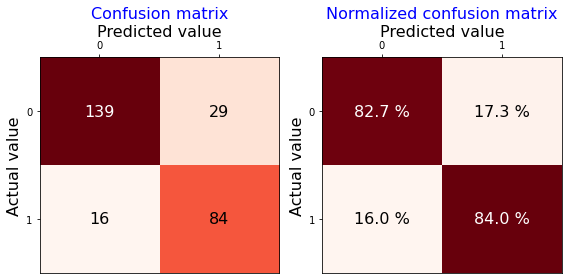

In [151]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(penalty="l2", C=1, solver="lbfgs", max_iter=7, multi_class="auto")
params = {
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'C': [i for i in np.arange(1, 5, 1)],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'max_iter': [i for i in np.arange(1, 15, 1)],
#     'multi_class': ['auto', 'ovr', 'multinomial'],
         }
clf_log = GridSearchCV(estimator=log, cv=10, scoring='accuracy', param_grid=params).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_log.best_params_)

log_cm_metrics, log_pred = evaluate_model(log, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        Random Forest
    </h4>
</div>

<img src="https://406167-1278791-raikfcquaxqncofqfm.stackpathdns.com/wp-content/uploads/2021/02/Random-Forest-Algorithm-1024x576.jpg" style="height:250px">

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier


best prarams: {}


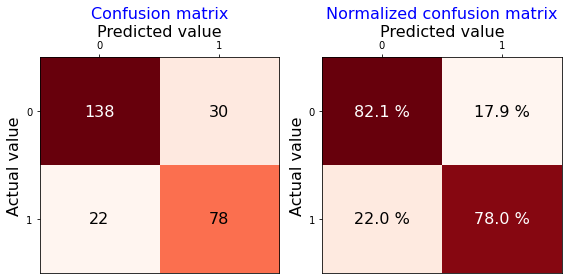

In [152]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini', n_estimators=50, max_depth=7, min_samples_split=8, 
                            min_samples_leaf=8)
params = {
#     'criterion': ['gini', 'entropy'],
#     'n_estimators': [10,20,30,50, 100, 125, 150, 200],
#     'max_depth': [i for i in np.arange(1, 15, 1)],
#     'min_samples_split': [i for i in np.arange(1, 15, 1)],
#     'min_samples_leaf': [i for i in np.arange(1, 15, 1)],
         }
clf_rf = GridSearchCV(estimator=rf, cv=10, scoring='accuracy', param_grid=params, n_jobs=-1)\
.fit(X_train_sm, y_train_sm)
print('best prarams:', clf_rf.best_params_)

rf_cm_metrics, rf_pred = evaluate_model(rf, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        Naive Bayes
    </h4>
</div>

<img src="https://www.researchgate.net/profile/Paolo-Dellaversana/publication/328020065/figure/fig5/AS:677213301121033@1538471641906/Naive-Bayes-classification-of-three-different-rock-types-based-on-nine-mineralogical.png" style="height:200px">

best prarams: {}
CPU times: user 85.3 ms, sys: 7.75 ms, total: 93.1 ms
Wall time: 109 ms


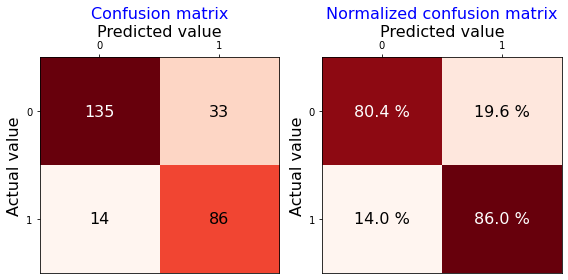

In [153]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bNB = BernoulliNB(alpha=1.5, binarize=0.0, fit_prior=False)

params = {
#     'alpha': [0.5, 1.0, 1.5, 2.0, 2.5],
#     'binarize': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5],
#     'fit_prior': [False, True],
         }
clf_bNB = GridSearchCV(estimator=bNB, cv=10, scoring='accuracy', param_grid=params, 
n_jobs=-1).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_bNB.best_params_)

bNB_cm_metrics, bNB_pred = evaluate_model(bNB, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        SVM
    </h4>
</div>

<img src="https://miro.medium.com/max/410/1*MHtUN-DgYPZWPe2dU5G6Lg.png" style="height:200px">

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC


best prarams: {}
CPU times: user 414 ms, sys: 9.68 ms, total: 424 ms
Wall time: 534 ms


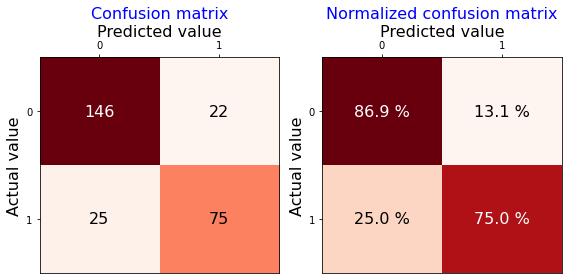

In [154]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1.5, degree=0.0, probability=True)

params = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'C': [0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5],
#     'degree': [0,0.01,0.02,0.03,0.04],
         }
clf_svm = GridSearchCV(estimator=svm, cv=10, scoring='accuracy', param_grid=params, 
n_jobs=-1).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_svm.best_params_)

svm_cm_metrics, svm_pred = evaluate_model(svm, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        k-Nearest Neighbours
    </h4>
</div>

<img src="https://www.kdnuggets.com/wp-content/uploads/rapidminer-knn-image1.jpg" style="height:200px">

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier


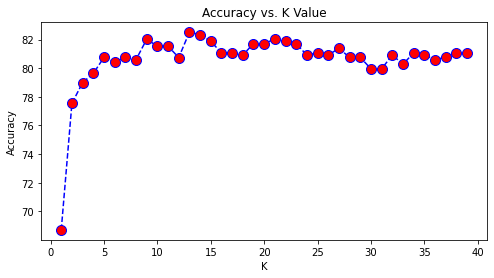

In [155]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

acc_list = []
for k in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    accuracy_scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    acc_knn = round(accuracy_scores.mean()*100, 2)
#     acc_knn = evaluate_model(knn, X_train, y_train)
    acc_list.append(acc_knn)
    
plt.figure(figsize=(8,4))
plt.plot(range(1,40),acc_list,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [156]:
k_max_list = [i for i in acc_list]
k_max = acc_list.index(max(k_max_list))+1
print(k_max)

13


best prarams: {}
CPU times: user 92.6 ms, sys: 7.7 ms, total: 100 ms
Wall time: 120 ms


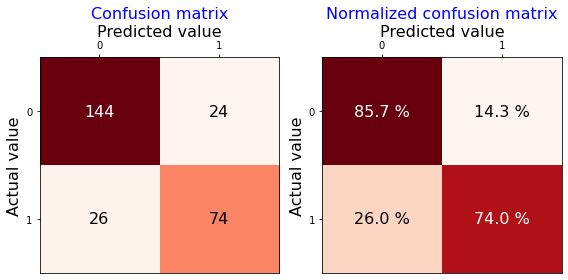

In [157]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='auto', leaf_size=0, weights='distance', p=1)
params = {
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#     'leaf_size': [i for i in np.arange(0, 15, 1)],
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2, 3, 4, 5, 6],
         }
clf_knn = GridSearchCV(estimator=knn, cv=10, scoring='accuracy', param_grid=params, 
n_jobs=-1).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_knn.best_params_)

knn_cm_metrics, knn_pred = evaluate_model(knn, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        Stochastic Gradient Descent
    </h4>
</div>

<img src="https://miro.medium.com/max/1005/1*f0CuPDSWFUr9XGESWQ4JUA.png" style="height:200px">

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgdclassifier#sklearn.linear_model.SGDClassifier


best prarams: {}
CPU times: user 130 ms, sys: 7.98 ms, total: 138 ms
Wall time: 172 ms


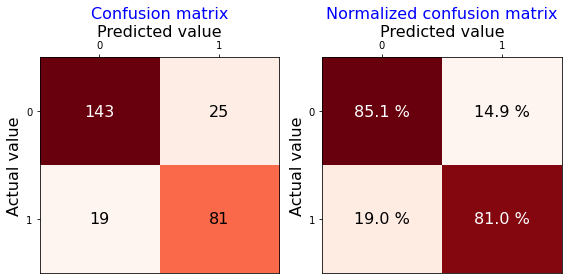

In [158]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier(loss='log', penalty='l1', alpha=0.0004, learning_rate='adaptive', eta0=0.03, 
                     power_t=0.01, n_iter_no_change=7)

params = {
#     'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 
#              'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
#     'penalty': ['l1', 'l2', 'elasticnet'],
#     'alpha': [i for i in np.arange(0.0001, 0.001, 1/10000)],
#     'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
#     'eta0': [0.01, 0.03, 0.05, 0.07],
#     'power_t': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3],
#     'validation_fraction': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2],
#     'n_iter_no_change': [1, 3, 5, 7, 9, 11],
         }
clf_sgdc = GridSearchCV(estimator=sgdc, cv=10, scoring='accuracy', param_grid=params, 
n_jobs=-1).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_sgdc.best_params_)

sgdc_cm_metrics, sgdc_pred = evaluate_model(sgdc, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        Gradient Boosting Trees
    </h4>
</div>

<img src="https://miro.medium.com/max/788/1*pEu2LNmxf9ttXHIALPcEBw.png" style="height:200px">

best prarams: {}
CPU times: user 99.5 ms, sys: 7.93 ms, total: 107 ms
Wall time: 126 ms


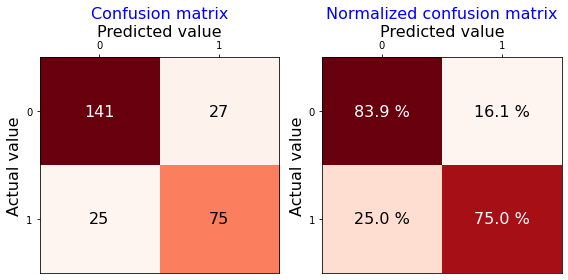

In [159]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(loss='deviance', learning_rate=4.5, n_estimators=1, subsample=0.95, 
                                 criterion='mse', max_depth=7)

params = {
#         'loss': ['deviance', 'exponential'],
#     'learning_rate': [0.3, 0.35, 0.45, 0.5, 0.6, 0.65, ],
#     'n_estimators': [0,1,2,3,4,5,6,7],
#     'subsample':[0.9,0.95,1,1.1],
#     'criterion': ['friedman_mse', 'mse', 'mae'],
#     'max_depth': [1,2,3,4,6,7,8,9],
         }
clf_gbc = GridSearchCV(estimator=gbc, cv=10, scoring='accuracy', param_grid=params, 
n_jobs=-1).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_gbc.best_params_)

gbc_cm_metrics, gbc_pred = evaluate_model(gbc, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        xgboost -> XGBClassifier
    </h4>
</div>

https://xgboost.readthedocs.io/en/latest/parameter.html

best prarams: {}
CPU times: user 1.29 s, sys: 25.8 ms, total: 1.31 s
Wall time: 1.3 s


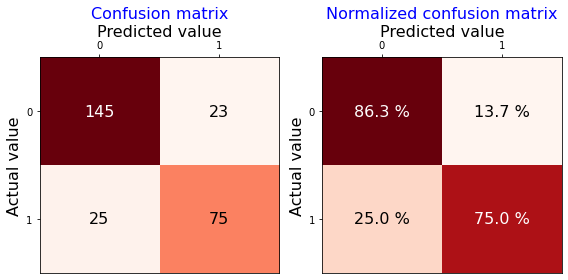

In [160]:
%%time
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(booster='gbtree', eval_metric='logloss', sketch_eps=0.0, eta=0.05, max_depth=10,
                   n_estimators=100, min_child_weight=2.9, max_delta_step=1, subsample=0.95, 
                    use_label_encoder=False)

params = {
#     'sketch_eps': [i for i in np.arange(0, 0.1, 1/100)],
#     'eta': [0.01,0.03,0.05,0.07,0.09],
#     'max_depth': [i for i in np.arange(0, 15, 1)],
#     'n_estimators': [90,95,100,110],
#     'min_child_weight' : [2.5,2.6,2.7,2.8,2.9,3],
#     'max_delta_step':[0,1,1.5,2],
#     'subsample':[0.9,0.95,1]
         }
clf_xgb = GridSearchCV(estimator=xgb, cv=5, scoring='accuracy', param_grid=params).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_xgb.best_params_)

xgb_cm_metrics, xgb_pred = evaluate_model(xgb, X_train_sm, y_train_sm, X_test, y_test, params)

<a id='4.2'></a>
<div class="alert alert-block alert-info">
   <h3>
        Model selection - final
   </h3>
</div>

In [161]:
'''
    # accuracy (ACC)
    ACC = round((TP + TN) / (TP + TN + FP + FN), 2)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round(TP / (TP + FN), 2)
    
    # Specificity, selectivity or true negative rate (TNR)
    TNR = round(TN / (TN + FP), 2)
    
    # Precision or positive predictive value
    PPV = round(TP / (TP + FP), 2)
    
    # F1 score
    F1 = round(2*TP / (2*TP + FP + FN), 2)
'''

metrics = ["Accuracy", "True Negative Rate", "True Positive Rate", "Precision", "F1 Score"]

log_metrics = log_cm_metrics.loc[:, metrics]
rf_metrics = rf_cm_metrics.loc[:, metrics]
bNB_metrics = bNB_cm_metrics.loc[:, metrics]
svm_metrics = svm_cm_metrics.loc[:, metrics]
knn_metrics = knn_cm_metrics.loc[:, metrics]
sgdc_metrics = sgdc_cm_metrics.loc[:, metrics]
gbc_metrics = gbc_cm_metrics.loc[:, metrics]
xgb_metrics = xgb_cm_metrics.loc[:, metrics]

df_models = pd.concat([log_metrics, rf_metrics, bNB_metrics, svm_metrics, knn_metrics, sgdc_metrics, 
                       gbc_metrics, xgb_metrics], axis=0)
df_models.index = ["log", "rf", "bNB", "svm", "knn", "sgdc", "gbc", "xgb"]
df_models = df_models.sort_values(["Accuracy", "True Positive Rate"], ascending=False)
df_models

,Accuracy,True Negative Rate,True Positive Rate,Precision,F1 Score
sgdc,0.84,0.85,0.81,0.76,0.79
log,0.83,0.83,0.84,0.74,0.79
bNB,0.82,0.80,0.86,0.72,0.79
svm,0.82,0.87,0.75,0.77,0.76
xgb,0.82,0.86,0.75,0.77,0.76
rf,0.81,0.82,0.78,0.72,0.75
gbc,0.81,0.84,0.75,0.74,0.74
knn,0.81,0.86,0.74,0.76,0.75


<a id='4.3'></a>
<div class="alert alert-block alert-info">
   <h3>
        Evaluation of the selected model
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        ROC & AUC
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Logistic Regression selected
</div>

In [162]:
y_test_prob = log_pred[:,1]

In [163]:
%%time
tpr_list = []
tnr_list = []
fpr_list = []
acc_list = []
thresholds_list = []
precision_list = []
npv_list = []

for i in range(0, 1000, 1):
    y_test_pred = (y_test_prob >= i/1000).astype('int')
    cm_train = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm_train.ravel()
    
    #____________ METRICS ____________#
    # Sensitivity, hit rate, recall, or true positive rate
    TPR_train = round(TP / (TP + FN), 2)
    # Specificity, selectivity or true negative rate (TNR)
    TNR_train = round(TN / (TN + FP), 2)
    # False positive rate or False alarm rate
    FPR_train = round(FP / (FP + TN), 2)
    # accuracy (ACC)
    acc_train = round((TP + TN) / (TP + TN + FP + FN), 2)
    # Precision or positive predictive value
    precision_train = round(TP / (TP + FP), 2)
    # negative predictive value (NPV)
    npv_train = round(TN / (TN + FN), 2)    

    tpr_list.append(TPR_train)
    tnr_list.append(TNR_train)
    fpr_list.append(FPR_train)
    acc_list.append(acc_train)
    thresholds_list.append(i/1000)
    precision_list.append(precision_train)
    npv_list.append(npv_train)

CPU times: user 249 ms, sys: 2.93 ms, total: 252 ms
Wall time: 250 ms


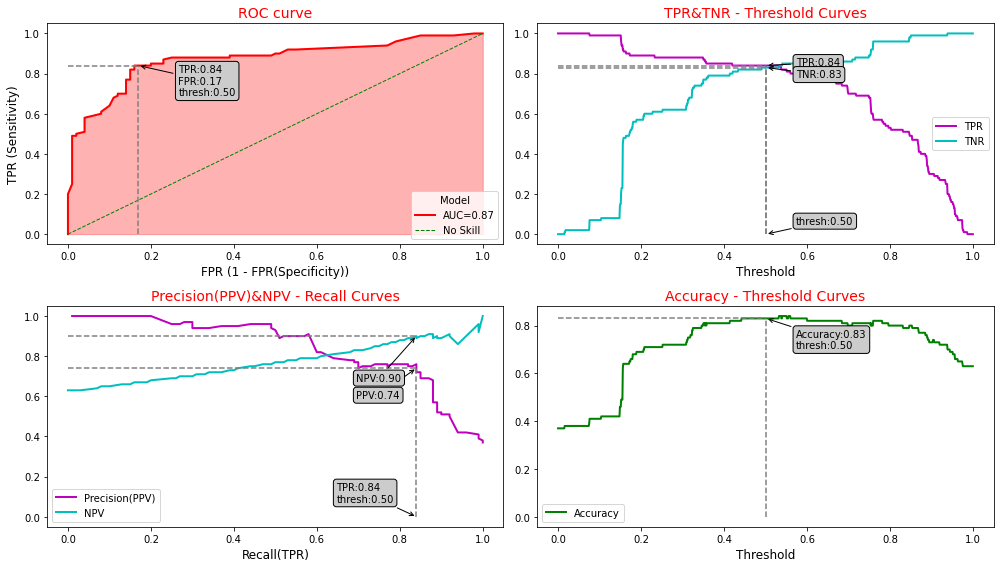

In [164]:
from sklearn.metrics import roc_auc_score

threshold=0.5
idx = next(x[0] for x in enumerate(thresholds_list) if x[1] > threshold)

# compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
lr_auc = roc_auc_score(y_test, y_test_prob)

#############################
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
#############################
### ROC Curve ###

axes[0, 0].plot(fpr_list, tpr_list, color='red', linewidth=2, 
                label=f'AUC={lr_auc:.2f}')
axes[0, 0].fill_between(fpr_list, tpr_list, 0, color='red', alpha=0.3)
axes[0, 0].plot([0, 1], [0, 1], color='green', linestyle='--', linewidth=1,
                label='No Skill')

axes[0, 0].set_xlabel('FPR (1 - FPR(Specificity))', size=12)
axes[0, 0].set_ylabel('TPR (Sensitivity)', size=12)
axes[0, 0].legend(title='Model')
axes[0, 0].set_title('ROC curve', color='red', size=14)

# Annotate #
axes[0, 0].plot([0,fpr_list[idx]], [tpr_list[idx],tpr_list[idx]], 'k--', color='gray')
axes[0, 0].plot([fpr_list[idx],fpr_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 0].annotate(
    f'TPR:{tpr_list[idx]:.2f}\nFPR:{fpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (fpr_list[idx], tpr_list[idx]), xytext =(-2 * -20, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### TPR and FPR at every threshold ###

axes[0, 1].plot(thresholds_list, tpr_list, color='m', linewidth=2, label='TPR')
axes[0, 1].plot(thresholds_list, tnr_list, color='c', linewidth=2, label='TNR')
axes[0, 1].set_xlabel('Threshold', size=12)
axes[0, 1].legend()
axes[0, 1].set_title('TPR&TNR - Threshold Curves', color='red', size=14)

axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')


# Annotate #
axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tpr_list[idx] ,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tnr_list[idx] ,tnr_list[idx]], 'k--', color='gray')

axes[0, 1].annotate(
    f'TPR:{tpr_list[idx]:.2f}',
    (thresholds_list[idx], tpr_list[idx]), xytext =(-2 * -15, 0), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(
    f'TNR:{tnr_list[idx]:.2f}',
    (thresholds_list[idx], tnr_list[idx]), xytext =(-2 * -15, -10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(f'thresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], 0), xytext =(-2 * -15, 10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Precision-Recall Curve ###

axes[1, 0].plot(tpr_list, precision_list, color='m', linewidth=2, label='Precision(PPV)')
axes[1, 0].plot(tpr_list, npv_list, color='c', linewidth=2, label='NPV')

axes[1, 0].set_xlabel('Recall(TPR)', size=12)
axes[1, 0].legend()
axes[1, 0].set_title('Precision(PPV)&NPV - Recall Curves', color='red', size=14)

# Annotate
axes[1, 0].plot([tpr_list[idx],tpr_list[idx]], [0,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [precision_list[idx] ,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [npv_list[idx] ,npv_list[idx]], 'k--', color='gray')

axes[1, 0].annotate(f'PPV:{precision_list[idx]:.2f}',
    (tpr_list[idx], precision_list[idx]), xytext =(-2 * 30, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'NPV:{npv_list[idx]:.2f}',
    (tpr_list[idx], npv_list[idx]), xytext =(-2 * 30, -45), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'TPR:{tpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (tpr_list[idx], 0), xytext =(-2 * 40, 15), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Accuracy at every threshold ###

axes[1, 1].plot(thresholds_list, acc_list, color='g', linewidth=2, label='Accuracy')
axes[1, 1].set_xlabel('Threshold', size=12)
axes[1, 1].legend()
axes[1, 1].set_title('Accuracy - Threshold Curves', color='red', size=14)

# Annotate #
axes[1, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,acc_list[idx]], 'k--', color='gray')
axes[1, 1].plot([0, thresholds_list[idx]], [acc_list[idx] ,acc_list[idx]], 'k--', color='gray')

axes[1, 1].annotate(
    f'Accuracy:{acc_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], acc_list[idx]), xytext =(-2 * -15, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

#############################
fig.tight_layout()
fig.show()

<div class="alert alert-block alert-success">
    <h4>
        Logarithmic loss
    </h4>
</div>

- A lower log loss, a higher model success, means better predictions

In [165]:
from sklearn.metrics import log_loss
# Running Log loss on training
print('The Log Loss on Test is: {:.2}'.format(log_loss(y_test, y_test_prob)))

The Log Loss on Test is: 0.43


<a id='5.0'></a>
<div class="alert alert-block alert-danger">
<h2>Submission</h2>
</div>

In [166]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(X, y)

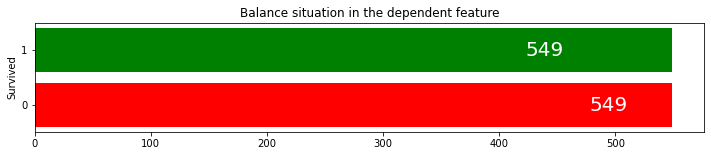

In [167]:
balanceOrInbalance(percentCol(pd.concat([X_sm, y_sm], axis=1), 'Survived'))

<div class="alert alert-block alert-warning">
        Threshold = 0.5
</div>

In [168]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty="l2", C=1, solver="lbfgs", max_iter=7, multi_class="auto")
model = BernoulliNB(alpha=1.5, binarize=0.0, fit_prior=False)
model = SGDClassifier(loss='log', penalty='l1', alpha=0.0004, learning_rate='adaptive', eta0=0.03, 
                     power_t=0.01, n_iter_no_change=7)    # 0.74641
model = SVC(kernel='rbf', C=1.5, degree=0.0, probability=True)     # 0.75837
model = XGBClassifier(booster='gbtree', eval_metric='logloss', sketch_eps=0.0, eta=0.05, max_depth=10,
                   n_estimators=100, min_child_weight=2.9, max_delta_step=1, subsample=0.95, 
                    use_label_encoder=False)     # 0.76315
model = KNeighborsClassifier(algorithm='auto', leaf_size=0, weights='distance', p=1)     # 0.75598
model = RandomForestClassifier(criterion='gini', n_estimators=50, max_depth=7, min_samples_split=8, 
                            min_samples_leaf=8)     # 0.76315
model = GradientBoostingClassifier(loss='deviance', learning_rate=4.5, n_estimators=1, subsample=0.95, 
                                 criterion='mse', max_depth=7)     # 0.73684

cv_kaggle = GridSearchCV(estimator=model, cv=10, scoring='accuracy', param_grid={}).fit(X_sm, y_sm)
y_pred_kaggle = cv_kaggle.predict(X_kaggle)
y_pred_proba_kaggle = cv_kaggle.predict_proba(X_kaggle)

<div class="alert alert-block alert-warning">
        Threshold = 0.65
</div>

In [169]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


model = XGBClassifier(booster='gbtree', eval_metric='logloss', sketch_eps=0.0, eta=0.05, max_depth=10,
                   n_estimators=100, min_child_weight=2.9, max_delta_step=1, subsample=0.95, 
                    use_label_encoder=False)     # 0.78229

cv_kaggle = GridSearchCV(estimator=model, cv=10, scoring='accuracy', param_grid={}).fit(X_sm, y_sm)
y_pred_kaggle = cv_kaggle.predict(X_kaggle)
y_pred_proba_kaggle = cv_kaggle.predict_proba(X_kaggle)

In [170]:
submission = gender_submission.drop('Survived', axis=1)
y_pred_kaggle = (y_pred_proba_kaggle [:,1] >= 0.65).astype('int')
submission['Survived'] = y_pred_kaggle
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [171]:
# Are our test and submission dataframes the same length?
if len(submission) == len(gender_submission):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [172]:
# Convert submisison dataframe to csv for submission to csv for Kaggle submisison
file_name = 'titanic_submission_kaggle_20220411.csv'
submission.to_csv(file_name, index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [173]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv(file_name)
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


<a id='5.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Results on the Kaggle website
   </h3>
</div>

https://www.kaggle.com/competitions/titanic/submit

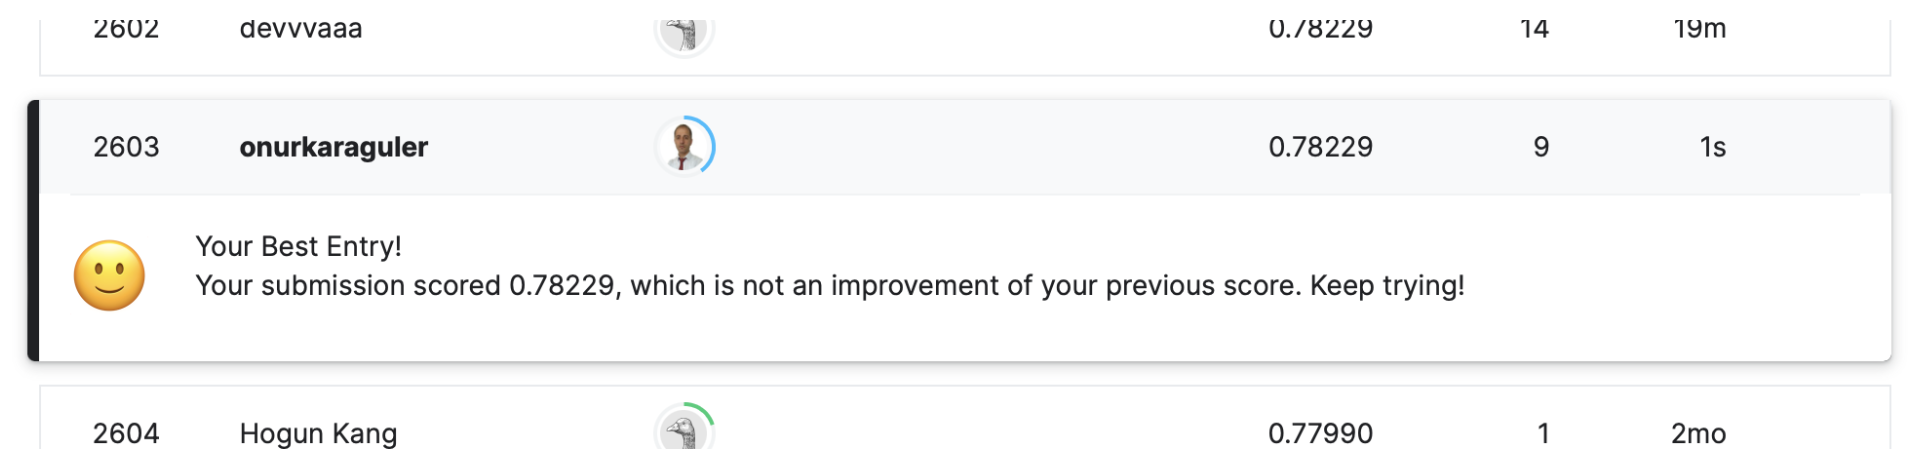

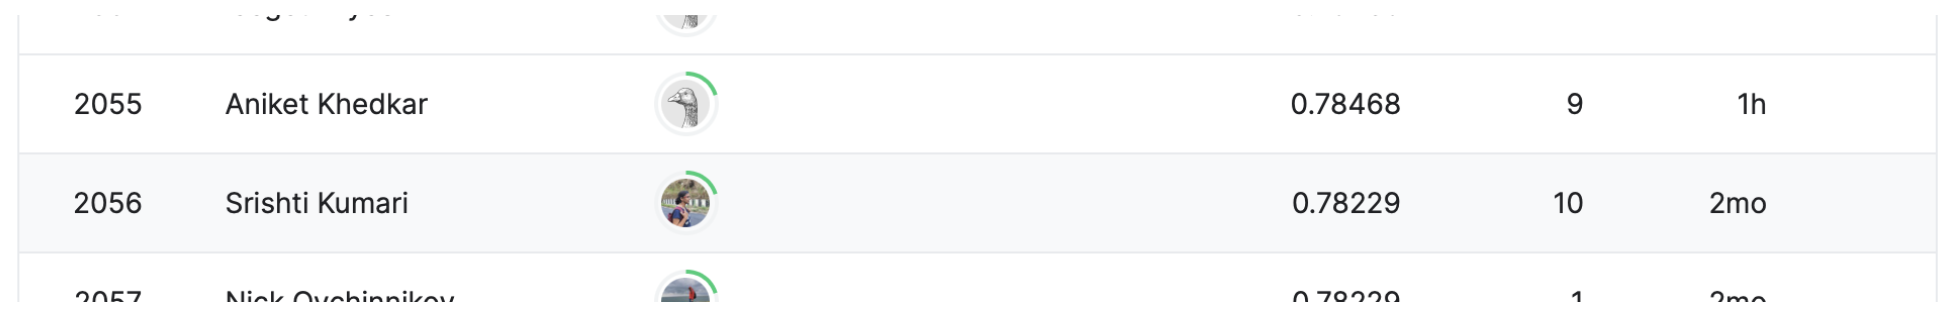

- Threshold = 0.5<br><br>
rf -> 0.77990 <br>
sgdc -> 0.77751 <br>
svm -> 0.77272 <br>
log -> 0.76794 <br>
knn -> 0.76794 <br>
nca -> 0.76794 <br>
gbc -> 0.76076 <br>
xgb -> 0.75837 <br>

- Threshold = 0.35<br>
xgb -> 0.7272 <br><br>
- Threshold = 0.55<br>
xgb -> 0.77511 <br><br>
- Threshold = 0.60<br>
xgb -> 0.77751 <br><br>
- Threshold = 0.65<br>
xgb -> 0.78708 <br><br>
- Threshold = 0.70<br>
xgb -> 0.77751 <br><br>
- Threshold = 0.75<br>
xgb -> 0.76315 <br>